See [fast_wcs_interp_torch_experiments_part3](fast_wcs_interp_torch_experiments_part3.ipynb) for previous part.

From those we find that just using the poly directly seems superior to any NN.  So here we implement that a little bit more cleanly and try fiddling with HPs a bit.

In [1]:
import time
from pathlib import Path
import itertools

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

### Cuda/torch preliminaries

In [2]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [3]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [4]:
def dconvert32(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float32)
def dconvert64(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=torch.float64)

# Poly-model

In [5]:
class ExpandToPoly(nn.Module):
    def __init__(self, polydeg, in_n):
        super().__init__()
        self._in_n = in_n
        self._polydeg = polydeg

        self.register_buffer('poly_powers', torch.from_numpy(self.make_power_array(polydeg, in_n)[..., np.newaxis].T))


    @property
    def in_n(self):
        return self._in_n
    @property
    def polydeg(self):
        return self._polydeg
    @property
    def out_n(self):
        return self.poly_powers.shape[-1]

    @staticmethod
    def make_power_array(degree, nfeaturesin):
        combs = [(),]
        for i in range(degree):
            combs.extend(itertools.combinations_with_replacement(range(nfeaturesin), i+1))
        pwr = np.zeros((len(combs), nfeaturesin))
        for i in range(len(combs)):
            for j in combs[i]:
                pwr[i, j] += 1
        return pwr

    def forward(self, x):
        xt = x[..., np.newaxis]
        xp = xt**self.poly_powers
        return torch.prod(xp, 1)

test_poly = ExpandToPoly(4,2)
assert test_poly.out_n == 15
assert test_poly.to(dtype=torch.float32).poly_powers.dtype == torch.float32
test_poly

ExpandToPoly()

In [6]:
class RescalingPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, transfer_layer_n=None):
        super().__init__()

        in_n = len(inbounds)
        self.inscale = [float(u-l) for l, u in inbounds]
        self.inoffset = [float(l) for l, u in inbounds]

        iscale_inv = 1/torch.tensor(self.inscale)
        self.inscale_layer = nn.Linear(in_n, in_n)
        self.inscale_layer.weight = nn.Parameter(torch.diag(iscale_inv), requires_grad=False)
        self.inscale_layer.bias = nn.Parameter(-torch.tensor(self.inoffset)*iscale_inv, requires_grad=False)
        
        out_n = len(outbounds)
        self.outscale = [float(u-l) for l, u in outbounds]
        self.outoffset = [float(l) for l, u in outbounds]

        self.outscale_layer = nn.Linear(out_n, out_n)
        self.outscale_layer.weight = nn.Parameter(torch.diag(torch.tensor(self.outscale)), requires_grad=False)
        self.outscale_layer.bias = nn.Parameter(torch.tensor(self.outoffset), requires_grad=False)

        self.poly_layer = ExpandToPoly(polydeg=polydeg, in_n=in_n)

        self.coeffs = nn.Linear(self.poly_layer.out_n, out_n, bias=False)
            
        self.primary_stack = nn.Sequential(self.inscale_layer,
                                            self.poly_layer,
                                            self.coeffs,
                                            self.outscale_layer)

    @property
    def in_n(self):
        return self.inscale_layer.in_features

    @property
    def out_n(self):
        return self.outscale_layer.out_features

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)

        yflat = self.primary_stack(xflat)

        return yflat.reshape(*leading_dims, self.out_n)


    def set_coeffs_for_lstsq_solution(self, x, y, subsample=None, seed=42):
        assert x.shape[-1] == self.in_n
        assert y.shape[-1] == self.out_n
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

        if subsample is not None:
            if seed is not None:
                torch.manual_seed(seed)
            ssample = torch.randperm(xflat.shape[0])[:subsample]
            xflat = xflat[ssample]
            yflat = yflat[ssample]

        p = self.poly_layer(self.inscale_layer(xflat))
        ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

        soln = torch.linalg.lstsq(p, ydescaled)
        self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

        return soln
        
    # def inrescale(self, x):
    #     return (x - self.inoffset)/self.inscale

    # def outrescale(self, y):
    #     return y * self.outscale + self.outoffset


model_test = RescalingPolyModel([(1,2), (3,4)], [(5,6)], 3).to(dtype=torch.float32)

in_test = torch.tensor([[1.5, 3.5]]).to(dtype=torch.float32)
np.testing.assert_allclose(model_test.inscale_layer(in_test).cpu().numpy()[0], np.array([0.5,0.5]))
res_test = model_test(in_test)
res_test, (res_test - model_test.outscale_layer.bias)/model_test.outscale_layer.weight

(tensor([[5.1619]], grad_fn=<ViewBackward0>),
 tensor([[0.1619]], grad_fn=<DivBackward0>))

In [7]:
model_test.inscale_layer(in_test)

tensor([[0.5000, 0.5000]])

In [8]:
model_test.poly_layer(model_test.inscale_layer(in_test))

tensor([[1.0000, 0.5000, 0.5000, 0.2500, 0.2500, 0.2500, 0.1250, 0.1250, 0.1250,
         0.1250]])

In [9]:
model_test.set_coeffs_for_lstsq_solution(in_test, torch.Tensor([[2.5]]))
print(model_test(in_test))
model_test.set_coeffs_for_lstsq_solution(in_test, torch.Tensor([[5.5]]))
print(model_test(in_test))

tensor([[2.5000]], grad_fn=<ViewBackward0>)
tensor([[5.5000]], grad_fn=<ViewBackward0>)


OK this all looks right

# Data loading

In [10]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [11]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [12]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [13]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [14]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [15]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-04-19 17:13:46,815 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [16]:
def resample_to_slit(slit, model_spec=phoenix_spec, factor=10):
    wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

    msk = (wls[0] <= model_spec.spectral_axis) & (model_spec.spectral_axis<=wls[-1])

    phoenix_sub_spec = Spectrum1D(spectral_axis=model_spec.spectral_axis[msk], 
                                            flux=model_spec.flux[msk])

    dmodel = np.diff(model_spec.spectral_axis[msk])

    phoenix_lowres_wls_dlamb = np.max(dmodel)*factor
    phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                    wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                    phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

    return FluxConservingResampler().resample1d(phoenix_sub_spec, 
                                (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

phoenix_lowres = resample_to_slit(slit)
len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

In [17]:
def ptrans_3feature(urand, sax):
    lptp = np.ptp(phoenix_lowres.spectral_axis)
    lmin = np.min(phoenix_lowres.spectral_axis)

    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1)
    do = (urand[2]*2 - 1)
    
    return l,ro << u.arcsec,do << u.arcsec


def make_grid_3feature(sizes, slit, sax=phoenix_lowres.spectral_axis, flatten=False, dconvert=dconvert32):
    mingrids = ptrans_3feature([0 for _ in sizes], sax)
    maxgrids = ptrans_3feature([1 for _ in sizes], sax)
    mgrids = [np.linspace(*e) for e in zip(mingrids, maxgrids, sizes)]
    l, ro, do = np.meshgrid(*mgrids)

    base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
    sc = base_sc.spherical_offsets_by(ro, do)
    outs = dconvert(slit.meta.wcs.world_to_pixel(sc, l))

    ins = dconvert((l.value, ro.value, do.value))

    ins = ins.permute(*np.roll(range(len(ins.shape)), -1))
    outs = outs.permute(*np.roll(range(len(outs.shape)), -1))

    if flatten:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])
    
    return ins, outs

grid_ins, grid_outs = make_grid_3feature((100,100,100), slit)
ins_plot, outs_plot = make_grid_3feature((17,17,17), slit, flatten=True)

/tmp/ipykernel_95/2397871784.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return cons(x).to(torch_device, dtype=torch.float32)


# Fitting experiments

In [44]:
def batch_train_from_pool(model, batch_size, n_batches, validation_period, 
                          pool=(grid_ins, grid_outs), valids=(grid_ins, grid_outs),
                          loss_fcn=None, optimizer=None, scheduler_gen=None, seed=42, shuffle=False):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = model.loss_fcn = nn.MSELoss().to(torch_device, dtype=torch.float32)
    if optimizer is None:
        optimizer = model.optimizer = torch.optim.Adam(model.parameters())
    elif callable(optimizer):
        optimizer = optimizer(model)

    if scheduler_gen is None:
        scheduler = None
    else:
        scheduler = model.scheduler = scheduler_gen(optimizer)

    ins = pool[0]
    if len(ins.shape) != 2:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
    outs = pool[1]
    if len(outs.shape) != 2:
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])

    valid_ins = valids[0]
    if len(valid_ins.shape) != 2:
        valid_ins = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
    valid_outs = valids[1]
    if len(valid_outs.shape) != 2:
        valid_outs = valid_outs.reshape(valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1])

    if not hasattr(model, 'batchis'):
        model.batchis = []
    if not hasattr(model, 'losses'):
        model.losses = []
        
    if not hasattr(model, 'batchis_validation'):
        model.batchis_validation = []
    if not hasattr(model, 'loss_validation'):
        model.loss_validation = []
        
    if not hasattr(model, 'learning_rates'):
        model.learning_rates = []

    llr = optimizer.param_groups[0]['lr']
    model.learning_rates.append((0, llr))
        
    pbar = tqdm(list(range(n_batches)))
    for batchi in pbar:
        if shuffle:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(ins.shape[0], size=batch_size)
            
        inb = ins[samples]
        outb = outs[samples]

        pred = model(inb)
        loss = loss_fcn(pred, outb)

        model.batchis.append(batchi)
        model.losses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchi % validation_period == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                model.batchis_validation.append(batchi)
                model.loss_validation.append(loss_fcn(model(valid_ins), valid_outs).item())

            if scheduler is not None:
                scheduler.step(model.loss_validation[-1])
                if llr != scheduler.get_last_lr()[-1]:
                    model.learning_rates.append((batchi, scheduler.get_last_lr()[-1]))
                    llr = model.learning_rates[-1][1]

            pbar.set_description(f'validation loss: {model.loss_validation[-1]}, lr: {llr}')
            pbar.refresh()
        
    model.eval()
    return model

def training_plots(model, pdata=(ins_plot, outs_plot), skipstart=-1, trainplot=True, residualsplot=True, dtypeconv=None):
    fig, axs = plt.subplots(int(trainplot) + int(residualsplot), 1, figsize=(12, 10))

    if dtypeconv is not None:
        pdata = [p.to(dtype=dtypeconv) for p in pdata]

    if not isinstance(axs, np.ndarray):
        axs = [axs]

    axi = 0
    if trainplot:
        axtrain = axs[axi]
        axi += 1
    if residualsplot:
        axres = axs[axi]
        axi += 1
        

    if trainplot:
        bi = np.array(model.batchis)
        ls = np.array(model.losses)
        biv = np.array(model.batchis_validation)
        lsv = np.array(model.loss_validation)

        msk1 = bi > skipstart
        msk2 = biv > skipstart
        
        axtrain.semilogy(bi[msk1], ls[msk1], '.', alpha=.5, ms=3, label='training')
        axtrain.semilogy(biv[msk2], lsv[msk2], 'o-', alpha=.5, label='validation')
        for lr in model.learning_rates:
            axtrain.axvline(lr[0], color='k', alpha=.75, ls=':')
        axtrain.legend(loc=0)
        axtrain.set_ylabel('loss')
        axtrain.set_xlabel('batch#')

    if residualsplot:
        pred = model(pdata[0])
        residuals = pred - pdata[1]
        
        for i, pxnm in enumerate('xy'):
            resi = residuals[:, i].detach().cpu()
            axres.scatter(np.arange(len(resi)), resi, s=2, label=pxnm, alpha=.5)
            axres.set_ylabel('residuals')
        axres.legend(loc=0)
        axres.set_xticks([])

    return fig

  0%|          | 0/20000 [00:00<?, ?it/s]

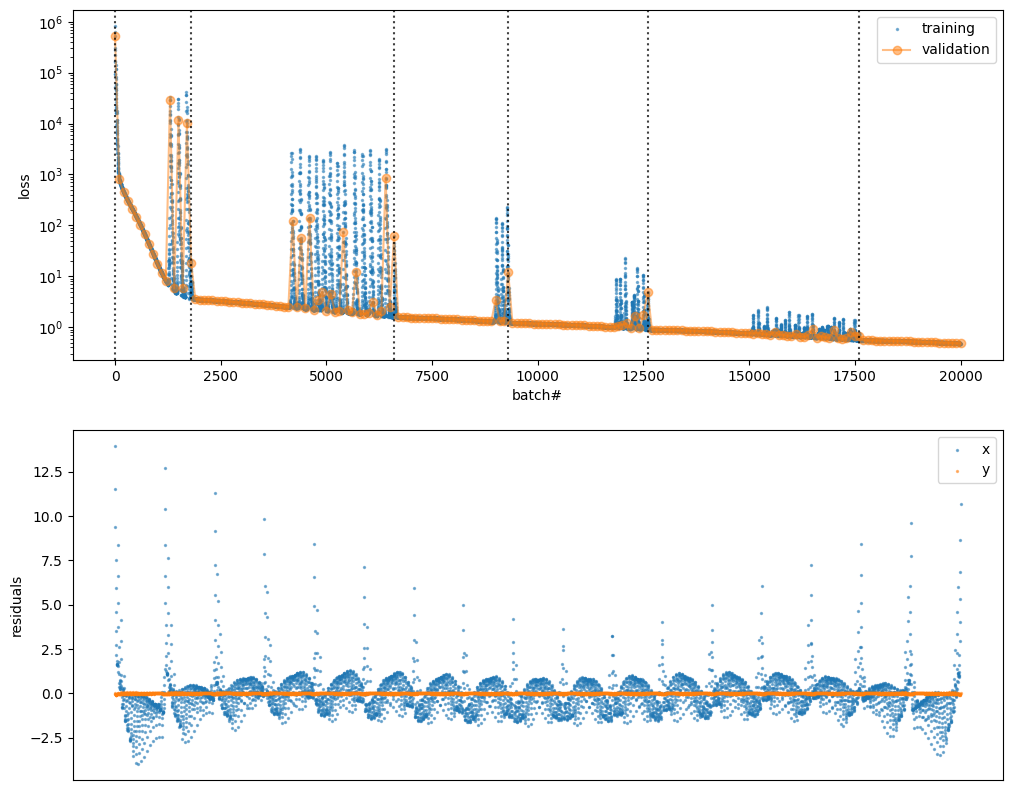

In [19]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

model = batch_train_from_pool(model, 1024*200, 20000, 100,
                              optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-1, fused=True),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.3, threshold=.001))

training_plots(model);

9.369663303004927e-07

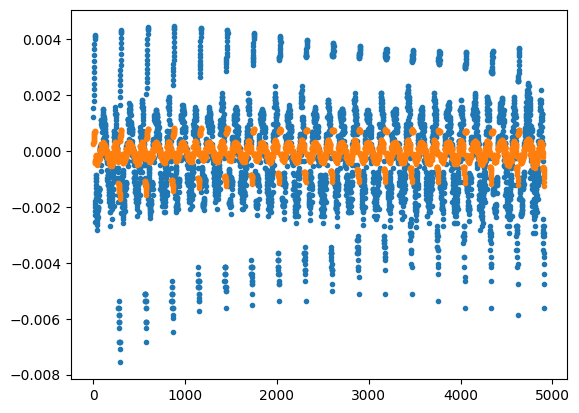

In [20]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, subsample=512)
plt.plot((model(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model(grid_ins), grid_outs).item()

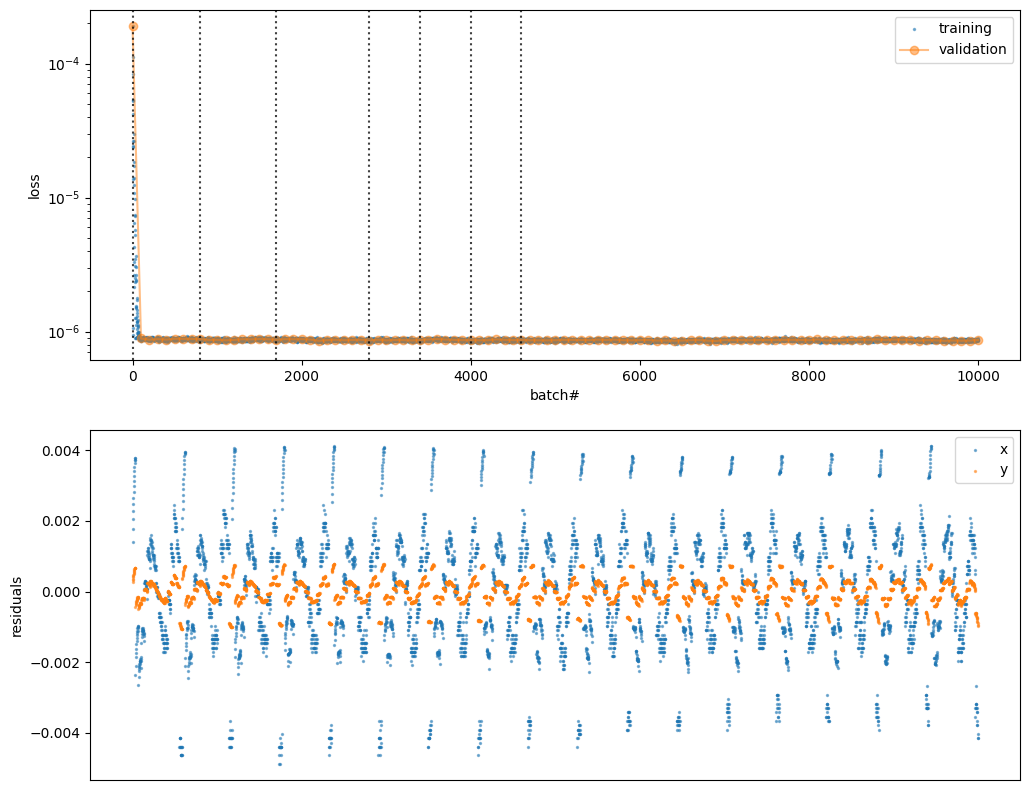

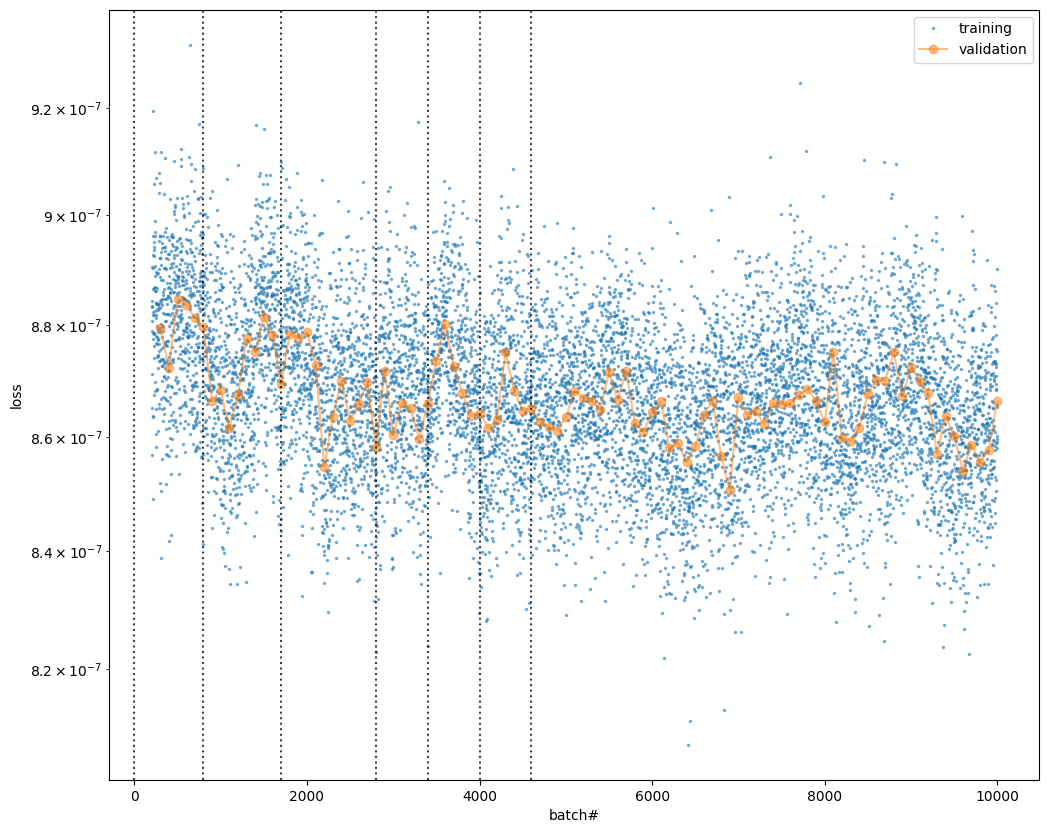

In [181]:
model = batch_train_from_pool(model, 1024*10, 10000, 100,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model)
training_plots(model, residualsplot=False, skipstart=200);

## Try doubles

In [193]:
grid_ins64, grid_outs64 = g64 = make_grid_3feature((100,100,100), slit_base_sc, dconvert=dconvert64 )
ins_plot64, outs_plot64 = p64 = make_grid_3feature((17,17,17), slit_base_sc, dconvert=dconvert64, flatten=True)

1.018311107297524e-06

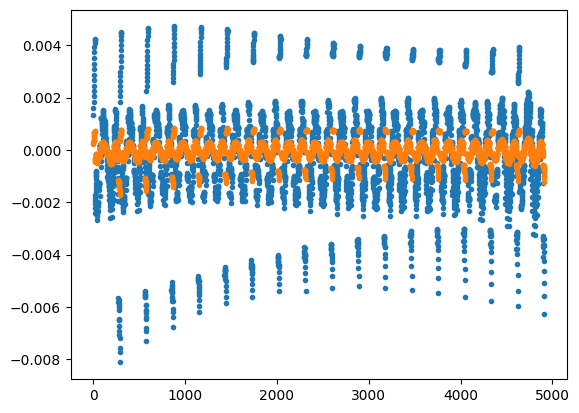

In [196]:
inscale = [(float(grid_ins64[...,i].min()), float(grid_ins64[...,i].max())) for i in range(grid_ins64.shape[-1])]
outscale = [(float(grid_outs64[...,i].min()), float(grid_outs64[...,i].max())) for i in range(grid_outs64.shape[-1])]
model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float64)

model.set_coeffs_for_lstsq_solution(grid_ins64, grid_outs64, subsample=512)
plt.plot((model(ins_plot64) - outs_plot64).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float64)(model(grid_ins64), grid_outs64).item()

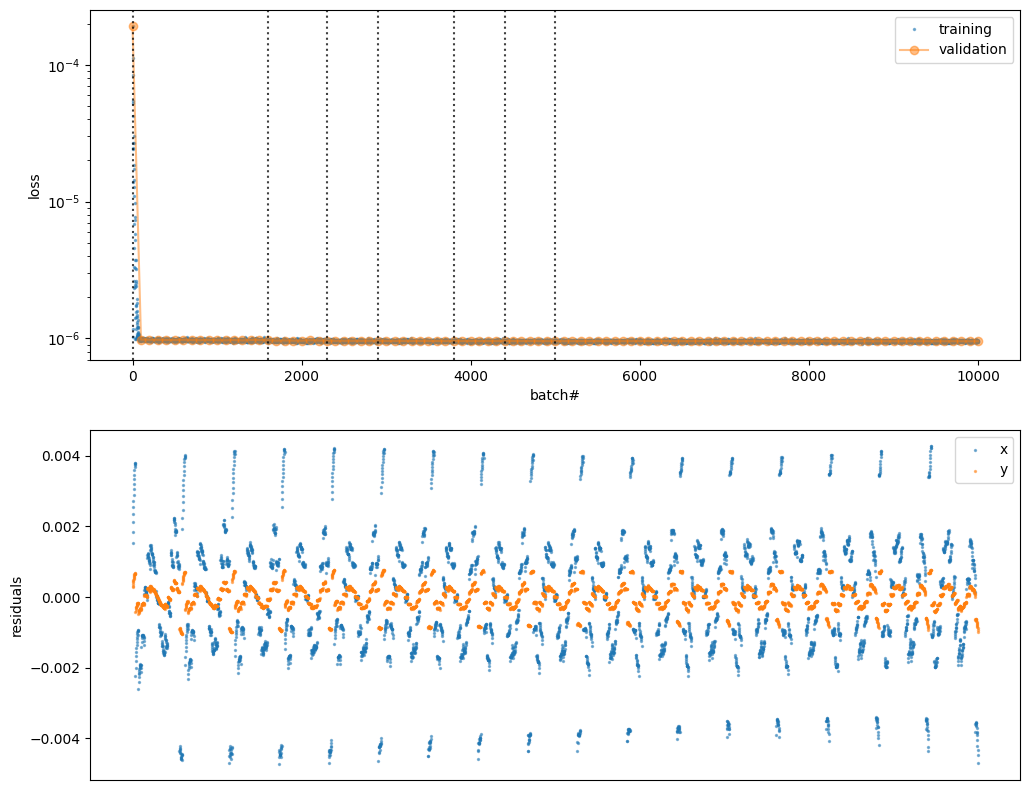

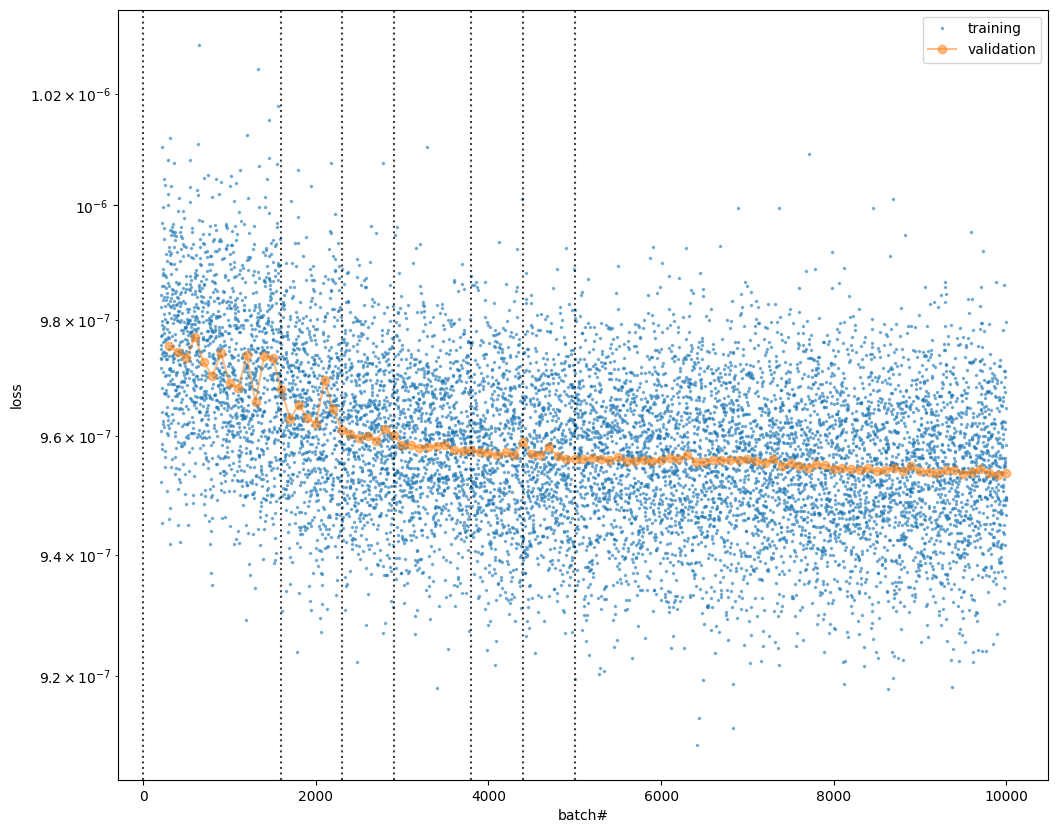

In [200]:
g64 = (grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64))
model = batch_train_from_pool(model, 1024*10, 10000, 100, 
                             pool=g64, valids=g64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model, p64)
training_plots(model, p64, residualsplot=False, skipstart=200);

Well that's  mysterious that double are *worse*... but eh, move on.

# Compare across slits

In [378]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths)}

slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

  0%|          | 0/4 [00:00<?, ?it/s]

In [379]:
models = {}

t = tqdm(slit_all.items())
for nm, sliti in t:
    t1 = time.time()
    t.set_description(nm)
    t.refresh()

    phoenix_lowres_i = resample_to_slit(sliti)
    grid_ins, grid_outs = d = make_grid_3feature((100,100,100), sliti, sax=phoenix_lowres_i.spectral_axis)

    inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
    outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
    model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

    model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, subsample=512)

    model = batch_train_from_pool(model, 1024*25, 2500, 100, pool=d, valids=d,
            optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
            scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

    models[nm] = model
    t2 = time.time()
    model.runtime = t2-t1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

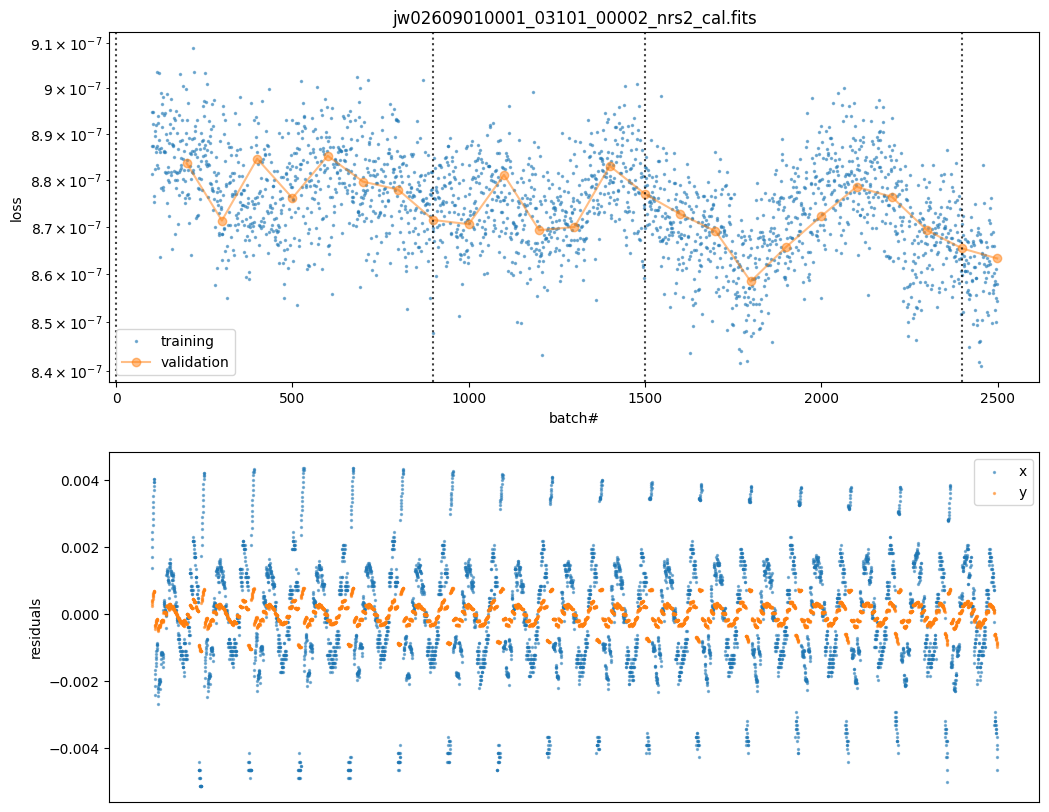

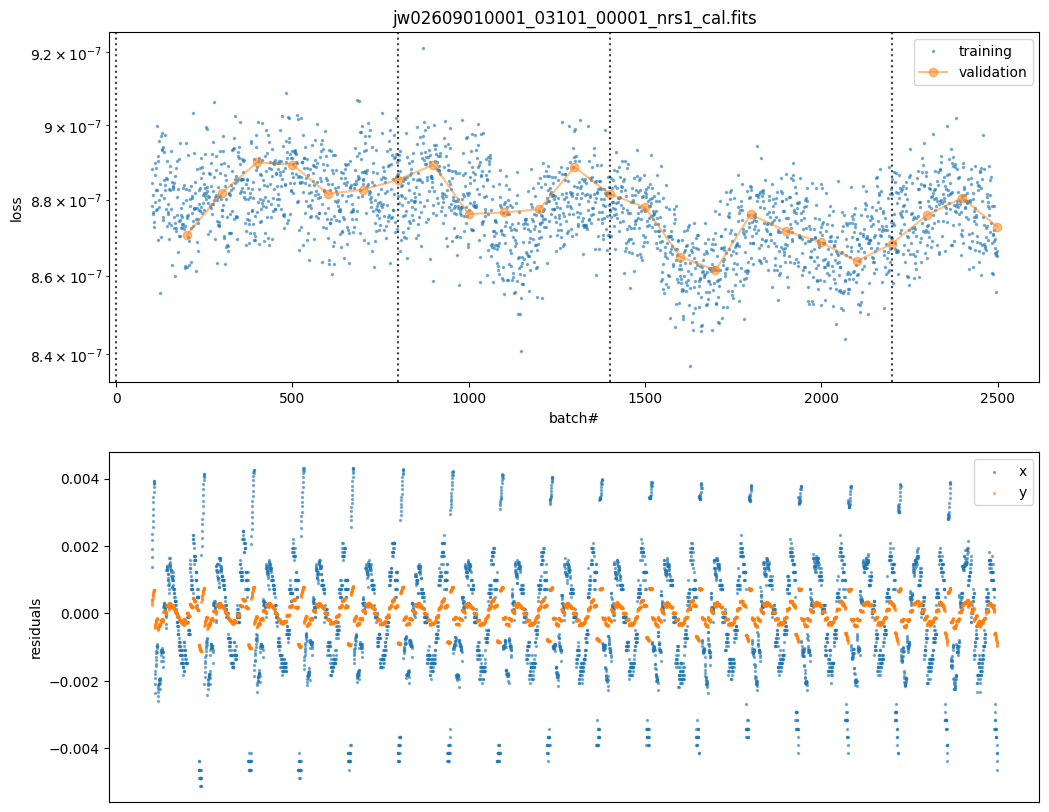

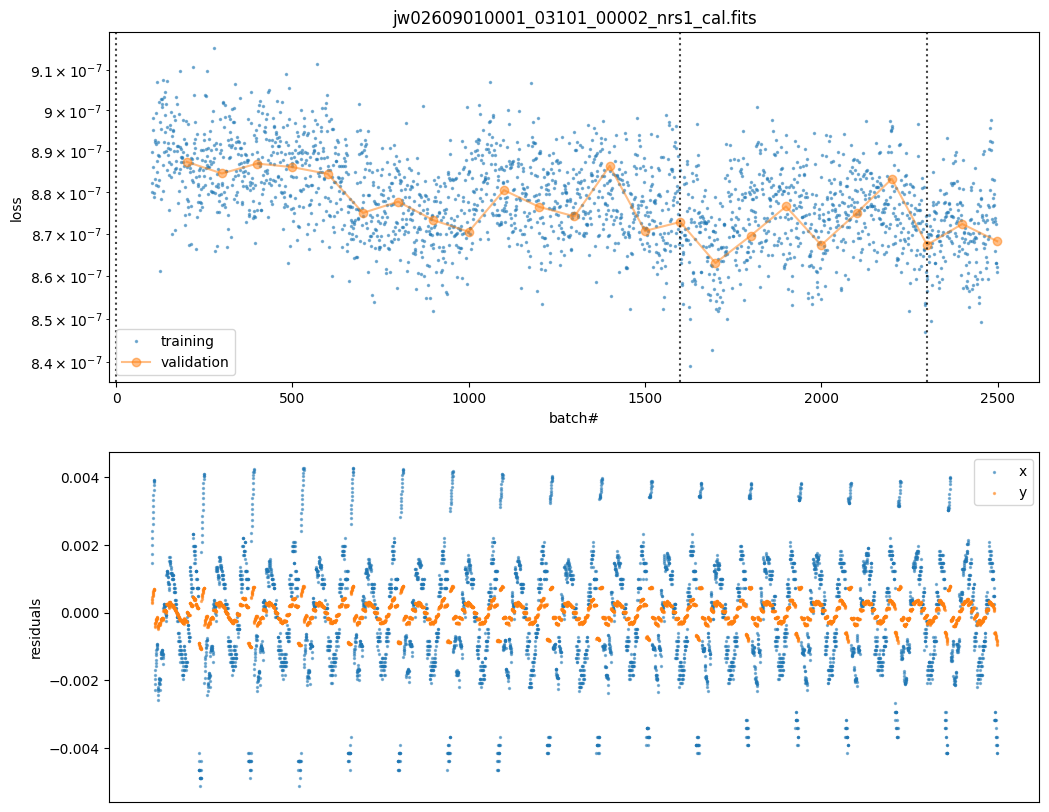

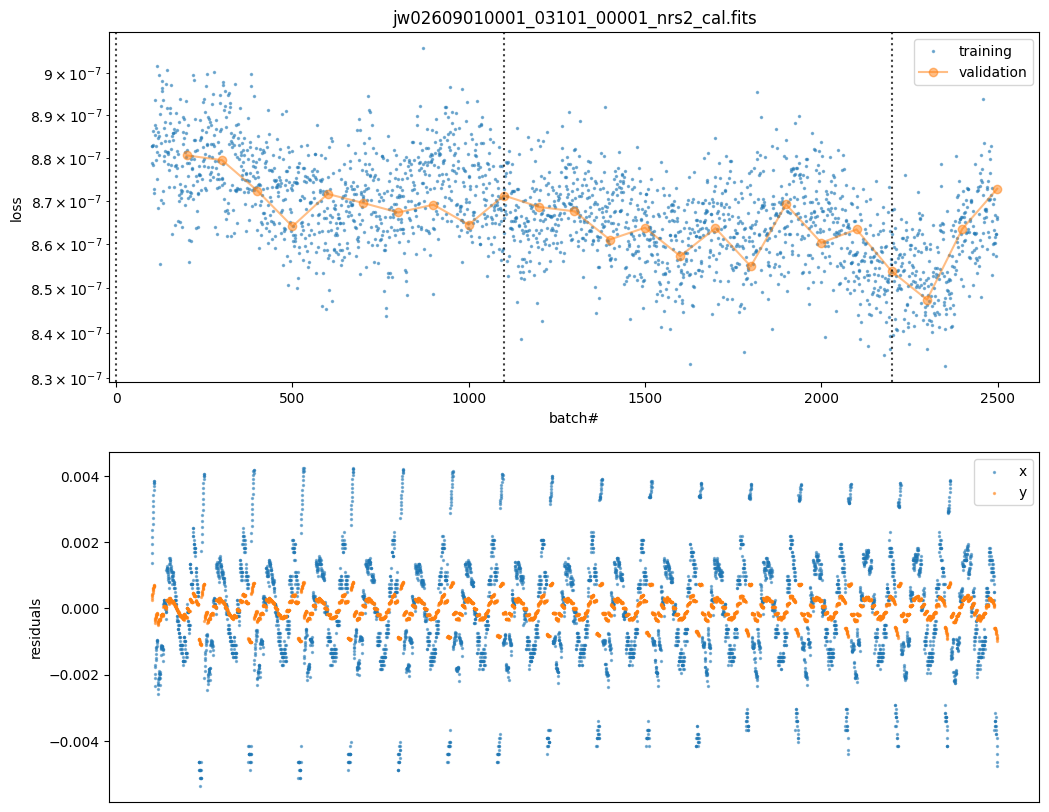

In [380]:
for nm,model in models.items():
    sliti = slit_all[nm]
    phoenix_lowres_i = resample_to_slit(sliti)
    pdat = make_grid_3feature((17,17,17), sliti, sax=phoenix_lowres_i.spectral_axis, flatten=True)

    fig = training_plots(model, pdat, skipstart=100)
    fig.axes[0].set_title(nm)

## Timing checks

Lets assume we want a grid that's 10x the spectral pixels but just one offset pixel (assuming we can express psf in pixels), how long does that take to infer?

In [381]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(20480)/10
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert32(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.5017920136451721


Now try 10x to simulate some sort of spatial offset

In [382]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(204800)/100
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert32(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.9799680113792419


The time seems to be entirely dominated by calling, etc, but clearly about the right ballpark of 1 ms

# An alternative formulation

Since $P = A x^\alpha x^\beta = A \exp[\alpha \ln{x} + \beta \ln{x}]$ we can reformulate the polynomial operation as a neural network with an exponential activation and logarithmic features, as long as the inputs are >0.

In [19]:
class LogLayer(nn.Module):
    def forward(self, x):
        return torch.log(x)

class ExpLayer(nn.Module):
    def forward(self, x):
        return torch.exp(x)

class RescalingLogLinearPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, fixpolypwr=False):
        super().__init__()

        in_n = len(inbounds)
        self.inscale = [float(u-l) for l, u in inbounds]
        self.inoffset = [float(l) for l, u in inbounds]

        iscale_inv = 1/torch.tensor(self.inscale)
        self.inscale_layer = nn.Linear(in_n, in_n)
        self.inscale_layer.weight = nn.Parameter(torch.diag(iscale_inv), requires_grad=False)
        self.inscale_layer.bias = nn.Parameter(-torch.tensor(self.inoffset)*iscale_inv, requires_grad=False)
        
        out_n = len(outbounds)
        self.outscale = [float(u-l) for l, u in outbounds]
        self.outoffset = [float(l) for l, u in outbounds]

        self.outscale_layer = nn.Linear(out_n, out_n)
        self.outscale_layer.weight = nn.Parameter(torch.diag(torch.tensor(self.outscale)), requires_grad=False)
        self.outscale_layer.bias = nn.Parameter(torch.tensor(self.outoffset), requires_grad=False)


        polypwrs = ExpandToPoly.make_power_array(polydeg, in_n)
        poly_n = polypwrs.shape[0]
        self.poly_linear_layer = nn.Linear(in_n, poly_n, bias=False)
        self.poly_linear_layer.weight = nn.Parameter(torch.Tensor(polypwrs), requires_grad=not fixpolypwr)

        self.coeffs = nn.Linear(poly_n, out_n, bias=False)
         
        self.primary_stack = nn.Sequential(self.inscale_layer,
                                            LogLayer(),
                                            self.poly_linear_layer,
                                            ExpLayer(),
                                            self.coeffs,
                                            self.outscale_layer)

    @property
    def in_n(self):
        return self.inscale_layer.in_features

    @property
    def out_n(self):
        return self.outscale_layer.out_features

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)

        yflat = self.primary_stack(xflat)

        return yflat.reshape(*leading_dims, self.out_n)


    def set_coeffs_for_lstsq_solution(self, x, y, subsample=512, seed=42, filterzeros=False):
        assert x.shape[-1] == self.in_n
        assert y.shape[-1] == self.out_n
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)
    
        if filterzeros:
            msk = torch.all(self.inscale_layer(xflat) > 0, 1)
            xflat = xflat[msk]
            yflat = yflat[msk]
    
        if subsample is not None:
            if seed is not None:
                torch.manual_seed(seed)
            ssample = torch.randperm(xflat.shape[0])[:subsample]
            xflat = xflat[ssample]
            yflat = yflat[ssample]
    
        explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
        
        if len(explayeridx) == 0:
            explayeridx = 1
        else:
            assert len(explayeridx) == 1, '> ExpLayer!  Highly unexpected'
            explayeridx = explayeridx[0]
    
        prestack = self.primary_stack[:(explayeridx+1)]
    
        p = prestack(xflat)
        ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

        soln = torch.linalg.lstsq(p, ydescaled)
        self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

        return soln

model_test = RescalingLogLinearPolyModel([(1,2), (3,4)], [(5,6)], 3).to(dtype=torch.float32)

in_test = torch.tensor([[1.5, 3.5]]).to(dtype=torch.float32)
np.testing.assert_allclose(model_test.inscale_layer(in_test).cpu().numpy()[0], np.array([0.5,0.5]))
res_test = model_test(in_test)
#(tensor([[4.9334]], grad_fn=<ViewBackward0>),
# tensor([[-0.0666]], grad_fn=<DivBackward0>))
res_test, (res_test - model_test.outscale_layer.bias)/model_test.outscale_layer.weight

(tensor([[4.8925]], grad_fn=<ViewBackward0>),
 tensor([[-0.1075]], grad_fn=<DivBackward0>))

Some testing code to make sure all is working as expected

In [20]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)


model2 = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

torch.testing.assert_close(model.poly_linear_layer.weight, model2.poly_layer.poly_powers[0].T)

def set_coeffs_for_lstsq_solution_test(self, x, y, subsample=512, seed=42, filterzeros=False, stage1only=True):
    assert x.shape[-1] == self.in_n
    assert y.shape[-1] == self.out_n
    xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
    yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

    if filterzeros:
        msk = torch.all(self.inscale_layer(xflat) > 0, 1)
        xflat = xflat[msk]
        yflat = yflat[msk]

    if subsample is not None:
        if seed is not None:
            torch.manual_seed(seed)
        ssample = torch.randperm(xflat.shape[0])[:subsample]
        xflat = xflat[ssample]
        yflat = yflat[ssample]

    explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
    
    if len(explayeridx) == 0:
        explayeridx = 1
    else:
        assert len(explayeridx) == 1, '> ExpLayer!  Highly unexpected'
        explayeridx = explayeridx[0]

    prestack = self.primary_stack[:(explayeridx+1)]
    print(prestack)

    p = prestack(xflat)

    if stage1only:
        return xflat, p
    
    ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

    soln = torch.linalg.lstsq(p, ydescaled)
    self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

    return soln

x1, p1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs)
x2, p2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs)

diff = p1-p2
torch.sum(torch.isfinite(diff))/diff.shape.numel(), torch.sum(torch.isfinite(p1) == torch.isfinite(p2))/p1.shape.numel()

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


(tensor(0.9866, device='cuda:0'), tensor(0.9866, device='cuda:0'))

A few percent are not finite...

In [21]:
torch.sum(torch.isfinite(p1))/p1.shape.numel(), torch.sum(torch.isfinite(p2))/p2.shape.numel()

(tensor(0.9866, device='cuda:0'), tensor(1., device='cuda:0'))

And its just the log/exp one...

In [22]:
ltz_msk = torch.any((model.inscale_layer(x1)<=0),1)
torch.all(torch.isfinite(diff[~ltz_msk]))

tensor(True, device='cuda:0')

Aha, so it's anything that has a feature <= 0

1.1920928955078125e-07

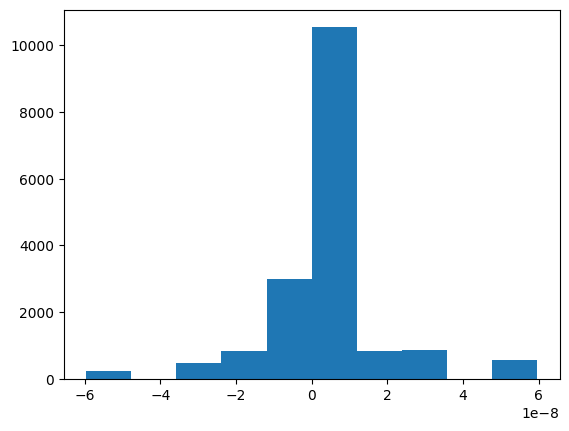

In [23]:
plt.hist(diff[~ltz_msk].cpu().numpy().ravel())
2**-23  # this is float32 precision, roughly

Aha!  So now we are at machine precision if you just ignore the zeros-ies

In [24]:
x1, p1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs, filterzeros=True)
x2, p2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs, filterzeros=True)

torch.sum(torch.isfinite(p1))/p1.shape.numel(), torch.sum(torch.isfinite(p2))/p2.shape.numel()

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


(tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))

In [25]:
torch.testing.assert_close(p1, p2)

They match!

In [26]:
s1 = set_coeffs_for_lstsq_solution_test(model, grid_ins, grid_outs, filterzeros=True, stage1only=False)
s2 = set_coeffs_for_lstsq_solution_test(model2, grid_ins, grid_outs, filterzeros=True, stage1only=False)

torch.testing.assert_close(s1.solution, s2.solution)

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): LogLayer()
  (2): Linear(in_features=3, out_features=35, bias=False)
  (3): ExpLayer()
)
Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ExpandToPoly()
)


And so do the solutions! What does the model then give?

nan

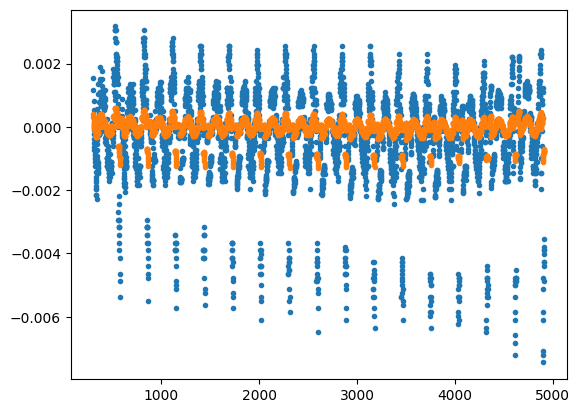

In [27]:
plt.plot((model(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model(grid_ins), grid_outs).item()

1.0737743423305801e-06

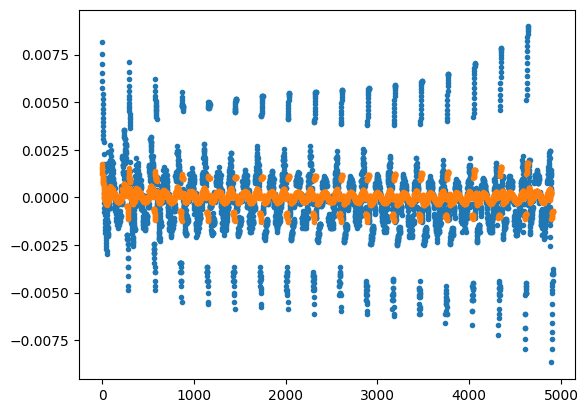

In [28]:
plt.plot((model2(ins_plot) - outs_plot).cpu().detach(), '.')

nn.MSELoss().to(torch_device, dtype=torch.float32)(model2(grid_ins), grid_outs).item()

The top outliers are missing from the logexp model, but I suppose then those are negative parts of the grid? Probably fixable by fiddling with scale anyway.

## Training Coeffs

In [29]:
inscale = [(float(grid_ins[...,i].min()), float(grid_ins[...,i].max())) for i in range(grid_ins.shape[-1])]
outscale = [(float(grid_outs[...,i].min()), float(grid_outs[...,i].max())) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)
model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)

model = batch_train_from_pool(model, 1024*10, 10000, 100,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

#training_plots(model)
#training_plots(model, residualsplot=False, skipstart=200);

  0%|          | 0/10000 [00:00<?, ?it/s]

Doh, nans in training

In [41]:
def batch_train_from_pool_nans(model, batch_size, n_batches, validation_period, 
                          pool=(grid_ins, grid_outs), valids=(grid_ins, grid_outs),
                          loss_fcn=None, optimizer=None, scheduler_gen=None, seed=42, shuffle=False, mask_nans=False, dtypeconv=None):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = model.loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = model.optimizer = torch.optim.Adam(model.parameters())
    elif callable(optimizer):
        optimizer = optimizer(model)

    if scheduler_gen is None:
        scheduler = None
    else:
        scheduler = model.scheduler = scheduler_gen(optimizer)

    ins = pool[0]
    if len(ins.shape) != 2:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
    outs = pool[1]
    if len(outs.shape) != 2:
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])

    valid_ins = valids[0]
    if len(valid_ins.shape) != 2:
        valid_ins = valid_ins.reshape(valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1])
    valid_outs = valids[1]
    if len(valid_outs.shape) != 2:
        valid_outs = valid_outs.reshape(valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1])

    if dtypeconv is not None:
        valid_ins = valid_ins.to(dtype=dtypeconv)
        valid_outs = valid_outs.to(dtype=dtypeconv)
        ins = ins.to(dtype=dtypeconv)
        outs = outs.to(dtype=dtypeconv)

    if not hasattr(model, 'batchis'):
        model.batchis = []
    if not hasattr(model, 'losses'):
        model.losses = []
        
    if not hasattr(model, 'batchis_validation'):
        model.batchis_validation = []
    if not hasattr(model, 'loss_validation'):
        model.loss_validation = []
        
    if not hasattr(model, 'learning_rates'):
        model.learning_rates = []

    llr = optimizer.param_groups[0]['lr']
    model.learning_rates.append((0, llr))
        
    pbar = tqdm(list(range(n_batches)))
    for batchi in pbar:
        if shuffle:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(ins.shape[0], size=batch_size)
            
        inb = ins[samples]
        outb = outs[samples]

        pred = model(inb)

        # if there are any nans, filter them out here.
        nanmsk = torch.all(torch.isfinite(pred), 1)
        if torch.sum(nanmsk)>0:
            assert torch.sum(nanmsk) > nanmsk.shape.numel()*0.5, "More than half of the inputs yield nans!"
            pred2 = model(inb[nanmsk])
            loss = loss_fcn(pred2, outb[nanmsk])
        else:
            loss = loss_fcn(pred, outb)

        model.batchis.append(batchi)
        model.losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batchi % validation_period == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                model.batchis_validation.append(batchi)
                valid_pred = model(valid_ins)
                vnanmsk = torch.all(torch.isfinite(valid_pred), 1)
                model.loss_validation.append(loss_fcn(valid_pred[vnanmsk], valid_outs[vnanmsk]).item())

            if scheduler is not None:
                scheduler.step(model.loss_validation[-1])
                if llr != scheduler.get_last_lr()[-1]:
                    model.learning_rates.append((batchi, scheduler.get_last_lr()[-1]))
                    llr = model.learning_rates[-1][1]

            pbar.set_description(f'validation loss: {model.loss_validation[-1]}, lr: {llr}')
            pbar.refresh()
        
    model.eval()
    return model



  0%|          | 0/10000 [00:00<?, ?it/s]

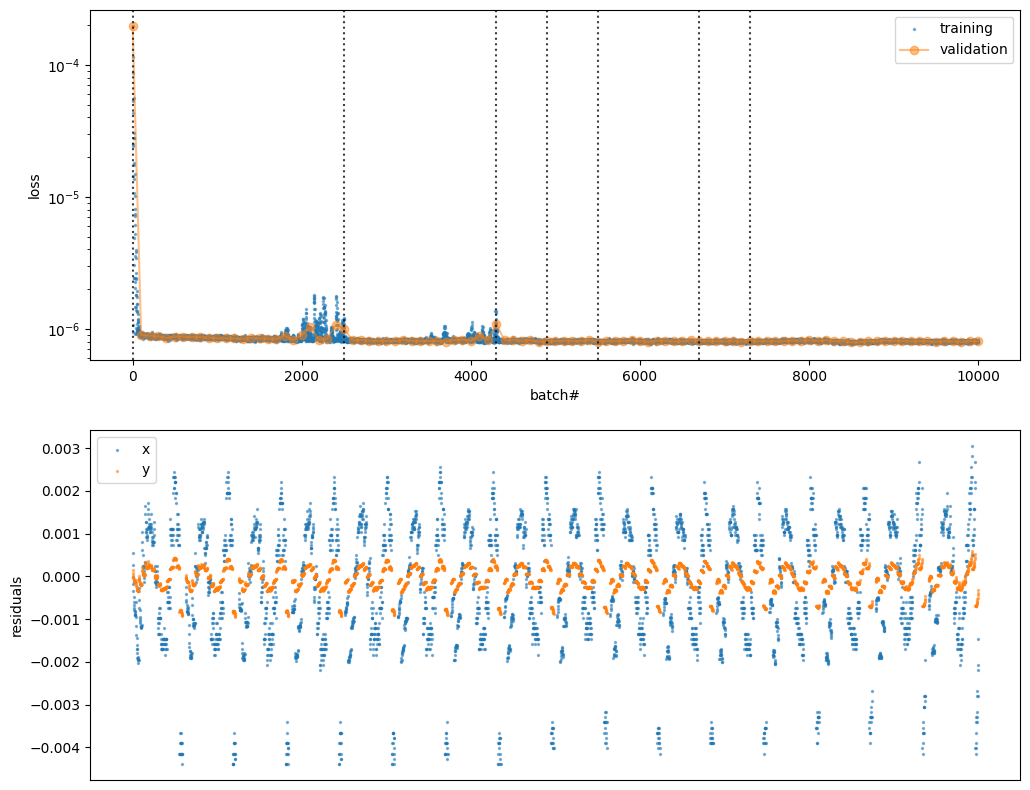

In [33]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)
model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model);

Huzzah!  What about without pre-setting coefficients?

  0%|          | 0/100000 [00:00<?, ?it/s]

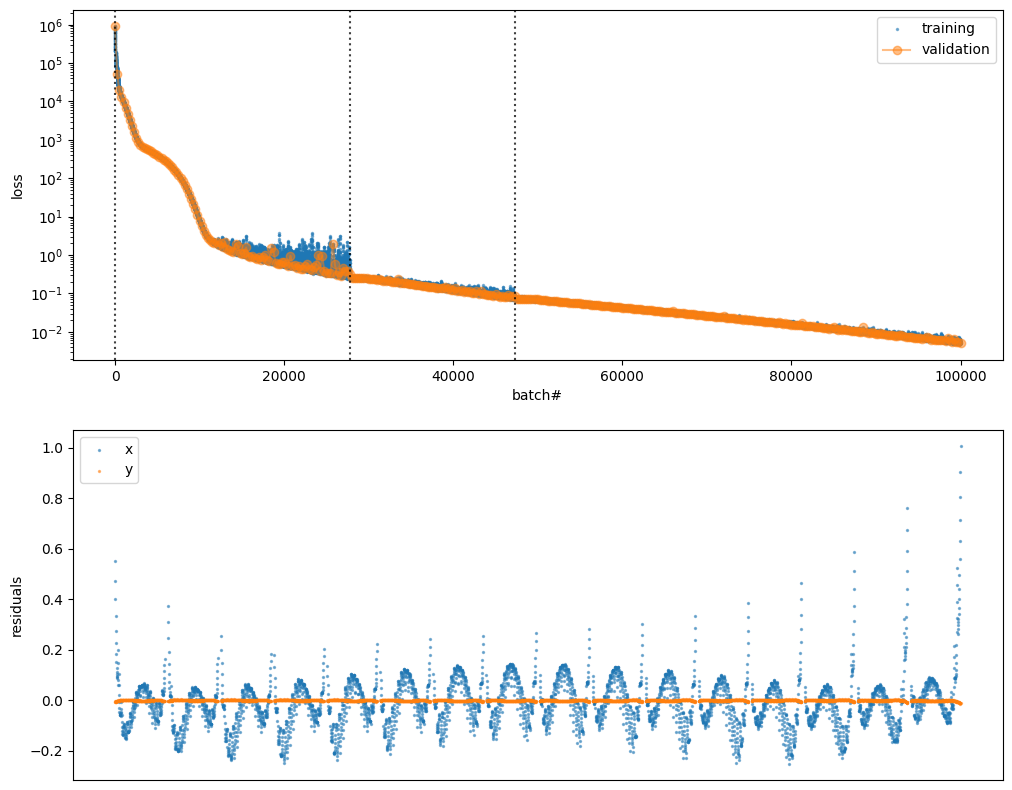

In [34]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 250,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.2, threshold=.001))

training_plots(model);

Can we re-formulate with complex numbers to make the 0s work?

In [35]:
t = torch.Tensor([1,2, -3, 0])
torch.log(t)

tensor([0.0000, 0.6931,    nan,   -inf])

In [36]:
t = torch.Tensor([1,2, -3, 0]).to(dtype=torch.complex64)
lt = torch.log(t)
lt, torch.exp(lt)

(tensor([0.0000+0.0000j, 0.6931+0.0000j, 1.0986+3.1416j,   -inf+0.0000j]),
 tensor([ 1.+0.0000e+00j,  2.+0.0000e+00j, -3.-2.6227e-07j,  0.+0.0000e+00j]))

In [37]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.complex64)
model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.complex64), grid_outs.to(dtype=torch.complex64), filterzeros=True)

loss_obj = nn.MSELoss().to(torch_device)
def cpx_loss(x, y):
    return loss_obj(x.real, y.real)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True,
                             pool=(grid_ins.to(dtype=torch.complex64), grid_outs.to(dtype=torch.complex64)), valids=(grid_ins.to(dtype=torch.complex64), grid_outs.to(dtype=torch.complex64)), loss_fcn=cpx_loss,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))


training_plots(model, pdata=(ins_plot.to(torch.complex64), outs_plot.to(torch.complex64)));

/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1140: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


RuntimeError: "compare_cuda" not implemented for 'ComplexFloat'

Ah, need to rethink comparisons, etc.  What if just the critical layer is complex?

In [31]:
class ComplexifyLayer(nn.Module):
    def forward(self, x):
        return torch.complex(x, torch.zeros_like(x))

class RealifyLayer(nn.Module):
    def forward(self, x):
        return x.real


minf = torch.complex(torch.Tensor([-np.inf]), torch.Tensor([0]))[0].to(torch_device)
class DeNanLayer(nn.Module):
    def forward(self, x):
        y = x.clone()
        y[torch.isnan(x)] = minf
        return y

class RescalingLogLinearSemiComplexPolyModel(nn.Module):
    def __init__(self, inbounds, outbounds, polydeg, fixpolypwr=False):
        super().__init__()

        in_n = len(inbounds)
        self.inscale = [float(u-l) for l, u in inbounds]
        self.inoffset = [float(l) for l, u in inbounds]

        iscale_inv = 1/torch.tensor(self.inscale)
        self.inscale_layer = nn.Linear(in_n, in_n)
        self.inscale_layer.weight = nn.Parameter(torch.diag(iscale_inv), requires_grad=False)
        self.inscale_layer.bias = nn.Parameter(-torch.tensor(self.inoffset)*iscale_inv, requires_grad=False)
        
        out_n = len(outbounds)
        self.outscale = [float(u-l) for l, u in outbounds]
        self.outoffset = [float(l) for l, u in outbounds]

        self.outscale_layer = nn.Linear(out_n, out_n)
        self.outscale_layer.weight = nn.Parameter(torch.diag(torch.tensor(self.outscale)), requires_grad=False)
        self.outscale_layer.bias = nn.Parameter(torch.tensor(self.outoffset), requires_grad=False)


        polypwrs = ExpandToPoly.make_power_array(polydeg, in_n)
        poly_n = polypwrs.shape[0]
        self.poly_linear_layer = nn.Linear(in_n, poly_n, bias=False).to(dtype=torch.complex64)
        self.poly_linear_layer.weight = nn.Parameter(torch.Tensor(polypwrs).to(dtype=torch.complex64), requires_grad=not fixpolypwr).to(dtype=torch.complex64)

        self.coeffs = nn.Linear(poly_n, out_n, bias=False)
         
        
        self.primary_stack = nn.Sequential(self.inscale_layer,
                                            ComplexifyLayer(),
                                            LogLayer(),
                                            self.poly_linear_layer,
                                            DeNanLayer(),
                                            ExpLayer(),
                                            RealifyLayer(),
                                            self.coeffs,
                                            self.outscale_layer)

    @property
    def in_n(self):
        return self.inscale_layer.in_features

    @property
    def out_n(self):
        return self.outscale_layer.out_features

    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)

        yflat = self.primary_stack(xflat)

        return yflat.reshape(*leading_dims, self.out_n)


    def set_coeffs_for_lstsq_solution(self, x, y, subsample=512, seed=42, filterzeros=False):
        assert x.shape[-1] == self.in_n
        assert y.shape[-1] == self.out_n
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)
    
        if filterzeros:
            msk = torch.all(self.inscale_layer(xflat) > 0, 1)
            xflat = xflat[msk]
            yflat = yflat[msk]
    
        if subsample is not None:
            if seed is not None:
                torch.manual_seed(seed)
            ssample = torch.randperm(xflat.shape[0])[:subsample]
            xflat = xflat[ssample]
            yflat = yflat[ssample]
    
        explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, RealifyLayer)]
        
        if len(explayeridx) == 0:
            explayeridx = 1
        else:
            assert len(explayeridx) == 1, '!1 RealifyLayer!  Highly unexpected'
            explayeridx = explayeridx[0]
    
        prestack = self.primary_stack[:(explayeridx+1)]
    
        p = prestack(xflat)
        ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

        soln = torch.linalg.lstsq(p, ydescaled)
        self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

        return soln

model_test = RescalingLogLinearSemiComplexPolyModel([(1,2), (3,4)], [(5,
                                                                      6)], 3)

in_test = torch.tensor([[1.5, 3.5]]).to(dtype=torch.float32)
np.testing.assert_allclose(model_test.inscale_layer(in_test).cpu().numpy()[0], np.array([0.5,0.5]))
res_test = model_test(in_test)
#(tensor([[4.9334]], grad_fn=<ViewBackward0>),
# tensor([[-0.0666]], grad_fn=<DivBackward0>))
res_test, (res_test - model_test.outscale_layer.bias)/model_test.outscale_layer.weight

/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1140: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


(tensor([[4.7623]], grad_fn=<ViewBackward0>),
 tensor([[-0.2377]], grad_fn=<DivBackward0>))

torch.return_types.linalg_lstsq(
solution=tensor([[ 1.3333e-02,  2.9927e-01],
        [ 9.7462e-01,  1.6840e-02],
        [-7.4616e-03, -2.9916e-01],
        [-5.8660e-03,  3.3972e-01],
        [ 1.0135e-02,  3.3013e-01],
        [-1.9181e-04, -5.3090e-03],
        [-1.0161e-04, -3.9188e-03],
        [ 2.8075e-06, -5.9510e-05],
        [-6.6856e-06,  2.9049e-05],
        [-2.5374e-06, -8.0779e-05],
        [ 6.8392e-04, -3.1274e-03],
        [-9.0009e-06, -4.8837e-04],
        [-1.8258e-06,  9.0460e-04],
        [-2.1205e-06, -1.6022e-05],
        [ 2.0420e-05,  2.0612e-04],
        [-5.3163e-07, -1.5935e-05],
        [ 7.2789e-07,  3.6091e-05],
        [-3.6579e-06, -3.8567e-05],
        [ 5.4465e-06,  3.6673e-05],
        [ 6.9699e-06,  4.4650e-05],
        [ 1.2259e-03,  2.0357e-02],
        [-3.7208e-05, -9.2841e-04],
        [-2.4966e-05, -1.1073e-04],
        [-7.2723e-06, -6.2330e-05],
        [-1.1153e-05, -1.2448e-04],
        [-4.6425e-06, -3.6488e-05],
        [ 6.9478e-06, 

  0%|          | 0/10000 [00:00<?, ?it/s]

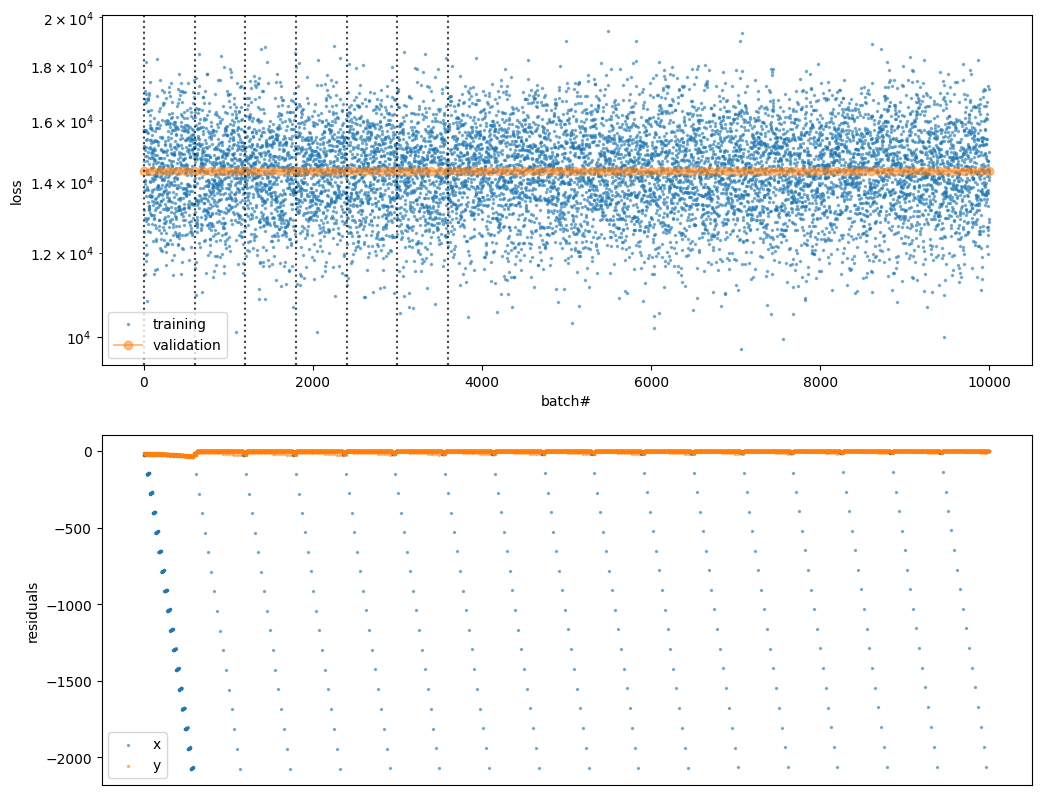

In [39]:
model = RescalingLogLinearSemiComplexPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device)
soln = model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=False)
print(soln)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model);

Hmm... why are the residuals non-sense?  What if we don't pre-solve?

  0%|          | 0/150000 [00:00<?, ?it/s]

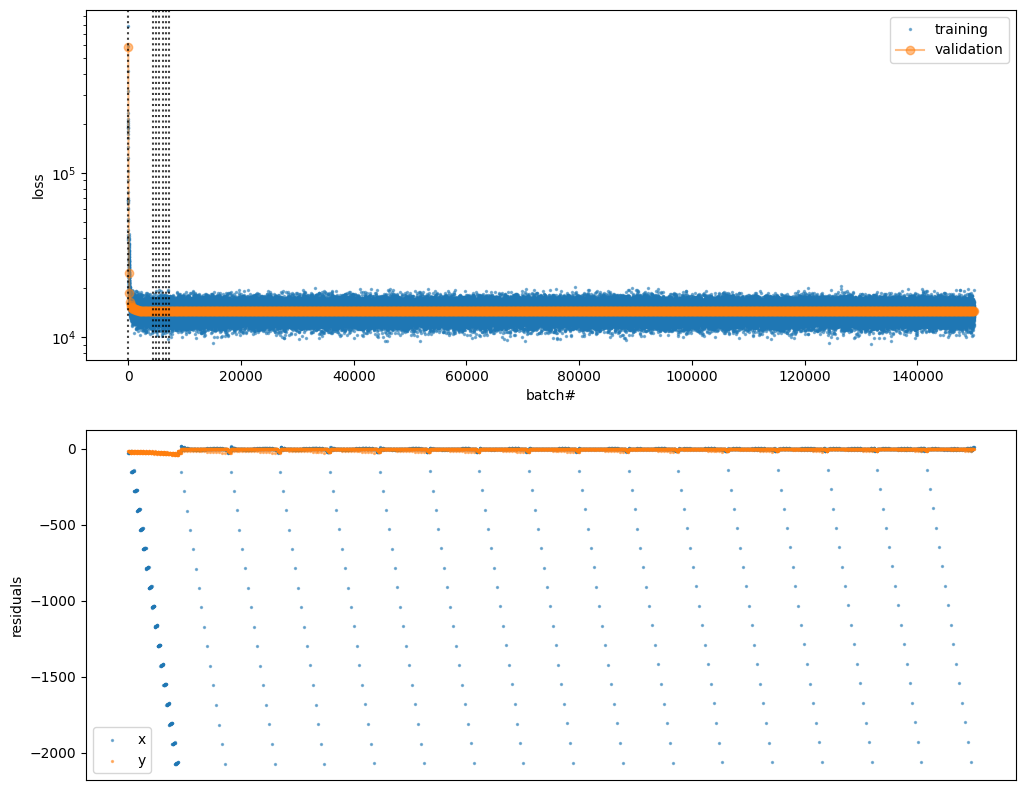

In [40]:
model = RescalingLogLinearSemiComplexPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device)

model = batch_train_from_pool_nans(model, 1024*10, 150000, 100,mask_nans=False,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-2, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.1, threshold=.001))

training_plots(model);

### Debugging from *before* adding the DeNanLayer

Well that seems fine, something must be wrong with the lstsq fit?

In [41]:
def set_coeffs_for_lstsq_solution_textcpx(self, x, y, subsample=512, seed=42, filterzeros=False):
    assert x.shape[-1] == self.in_n
    assert y.shape[-1] == self.out_n
    xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
    yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

    if filterzeros:
        msk = torch.all(self.inscale_layer(xflat) > 0, 1)
        xflat = xflat[msk]
        yflat = yflat[msk]

    if subsample is not None:
        if seed is not None:
            torch.manual_seed(seed)
        ssample = torch.randperm(xflat.shape[0])[:subsample]
        xflat = xflat[ssample]
        yflat = yflat[ssample]

    explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
    reallayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, RealifyLayer)]

    if len(reallayeridx) == 1:
        idx = reallayeridx[0]
    elif len(explayeridx) == 1:
        idx = explayeridx[0]
    else:
        raise RuntimeError('should be impossible for the layer idx to not be 1!')
    

    prestack = self.primary_stack[:(idx+1)]

    p = prestack(xflat)
    ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()

    soln = torch.linalg.lstsq(p, ydescaled)
    self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

    return soln

model = RescalingLogLinearSemiComplexPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device)

model2 = RescalingLogLinearPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

s1 = set_coeffs_for_lstsq_solution_textcpx(model, grid_ins, grid_outs, filterzeros=False)
s2 = model2.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)
s1, s2

(torch.return_types.linalg_lstsq(
 solution=tensor([[ 1.3333e-02,  2.9927e-01],
         [ 9.7462e-01,  1.6840e-02],
         [-7.4616e-03, -2.9916e-01],
         [-5.8660e-03,  3.3972e-01],
         [ 1.0135e-02,  3.3013e-01],
         [-1.9181e-04, -5.3090e-03],
         [-1.0161e-04, -3.9188e-03],
         [ 2.8075e-06, -5.9510e-05],
         [-6.6856e-06,  2.9049e-05],
         [-2.5374e-06, -8.0779e-05],
         [ 6.8392e-04, -3.1274e-03],
         [-9.0009e-06, -4.8837e-04],
         [-1.8258e-06,  9.0460e-04],
         [-2.1205e-06, -1.6022e-05],
         [ 2.0420e-05,  2.0612e-04],
         [-5.3163e-07, -1.5935e-05],
         [ 7.2789e-07,  3.6091e-05],
         [-3.6579e-06, -3.8567e-05],
         [ 5.4465e-06,  3.6673e-05],
         [ 6.9699e-06,  4.4650e-05],
         [ 1.2259e-03,  2.0357e-02],
         [-3.7208e-05, -9.2841e-04],
         [-2.4966e-05, -1.1073e-04],
         [-7.2723e-06, -6.2330e-05],
         [-1.1153e-05, -1.2448e-04],
         [-4.6425e-06, -3.6488e-

In [42]:
def set_coeffs_for_lstsq_solution_textcpx(self, x, y, subsample=512, seed=42, filterzeros=False):
    assert x.shape[-1] == self.in_n
    assert y.shape[-1] == self.out_n
    xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
    yflat = y.reshape(y.shape.numel() // self.out_n, self.out_n)

    if filterzeros:
        msk = torch.all(self.inscale_layer(xflat) > 0, 1)
        xflat = xflat[msk]
        yflat = yflat[msk]

    if subsample is not None:
        if seed is not None:
            torch.manual_seed(seed)
        ssample = torch.randperm(xflat.shape[0])[:subsample]
        xflat = xflat[ssample]
        yflat = yflat[ssample]

    explayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, ExpLayer)]
    reallayeridx = [i for i, l in enumerate(self.primary_stack) if isinstance(l, RealifyLayer)]

    if len(reallayeridx) == 1:
        idx = reallayeridx[0]
    elif len(explayeridx) == 1:
        idx = explayeridx[0]
    else:
        raise RuntimeError('should be impossible for the layer idx to not be 1!')
    

    prestack = self.primary_stack[:(idx+1)]

    p = prestack(xflat)
    ydescaled = (yflat - self.outscale_layer.bias)/self.outscale_layer.weight.diag()
    return xflat, p, ydescaled

    soln = torch.linalg.lstsq(p, ydescaled)
    self.coeffs.weight = nn.Parameter(torch.Tensor(soln.solution.T))

    return soln

model = RescalingLogLinearSemiComplexPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device)

model2 = RescalingLogLinearPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float32)

x1, p1, y1 = set_coeffs_for_lstsq_solution_textcpx(model, grid_ins, grid_outs)
x2, p2, y2 = set_coeffs_for_lstsq_solution_textcpx(model2, grid_ins, grid_outs)
torch.testing.assert_close(x1, x2)
torch.testing.assert_close(y1, y2)
torch.testing.assert_close(p1, p2)

AssertionError: Tensor-likes are not close!

Mismatched elements: 240 / 17920 (1.3%)
Greatest absolute difference: nan at index (30, 0) (up to 1e-05 allowed)
Greatest relative difference: nan at index (30, 0) (up to 1.3e-06 allowed)

Why are there still nans??

In [43]:
o1 = model.primary_stack[0](x1)
assert not torch.any(torch.isnan(o1)).item()
o1

tensor([[0.7576, 0.6364, 0.4242],
        [0.9495, 0.1212, 0.8990],
        [0.5051, 0.2929, 0.4444],
        ...,
        [0.3333, 0.4949, 0.2323],
        [0.3636, 0.6667, 0.5455],
        [0.4040, 0.0505, 0.8889]], device='cuda:0')

In [44]:
o2 = model.primary_stack[1](o1)
assert not torch.any(torch.isnan(o2)).item()
o2

tensor([[0.7576+0.j, 0.6364+0.j, 0.4242+0.j],
        [0.9495+0.j, 0.1212+0.j, 0.8990+0.j],
        [0.5051+0.j, 0.2929+0.j, 0.4444+0.j],
        ...,
        [0.3333+0.j, 0.4949+0.j, 0.2323+0.j],
        [0.3636+0.j, 0.6667+0.j, 0.5455+0.j],
        [0.4040+0.j, 0.0505+0.j, 0.8889+0.j]], device='cuda:0')

In [45]:
o3 = model.primary_stack[2](o2)
assert not torch.any(torch.isnan(o3)).item()
o3

tensor([[-0.2776+0.j, -0.4520+0.j, -0.8575+0.j],
        [-0.0518+0.j, -2.1102+0.j, -0.1065+0.j],
        [-0.6831+0.j, -1.2278+0.j, -0.8109+0.j],
        ...,
        [-1.0986+0.j, -0.7033+0.j, -1.4596+0.j],
        [-1.0116+0.j, -0.4055+0.j, -0.6061+0.j],
        [-0.9062+0.j, -2.9857+0.j, -0.1178+0.j]], device='cuda:0')

In [46]:
o4 = model.primary_stack[3](o3)
#assert not torch.any(torch.isnan(o4)).item() # this one nans are expected
o4

tensor([[ 0.0000+0.j, -0.2776+0.j, -0.4520+0.j,  ..., -2.6189+0.j, -3.0243+0.j,
         -3.4298+0.j],
        [ 0.0000+0.j, -0.0518+0.j, -2.1102+0.j,  ..., -4.4334+0.j, -2.4297+0.j,
         -0.4259+0.j],
        [ 0.0000+0.j, -0.6831+0.j, -1.2278+0.j,  ..., -4.0775+0.j, -3.6606+0.j,
         -3.2437+0.j],
        ...,
        [ 0.0000+0.j, -1.0986+0.j, -0.7033+0.j,  ..., -4.3259+0.j, -5.0822+0.j,
         -5.8385+0.j],
        [ 0.0000+0.j, -1.0116+0.j, -0.4055+0.j,  ..., -2.0232+0.j, -2.2239+0.j,
         -2.4245+0.j],
        [ 0.0000+0.j, -0.9062+0.j, -2.9857+0.j,  ..., -6.2069+0.j, -3.3390+0.j,
         -0.4711+0.j]], device='cuda:0')

In [47]:
o5 = model.primary_stack[4](o4)
assert not torch.any(torch.isnan(o5)).item()
o5[torch.isnan(o4)]

tensor([-inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j,
        -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf+0.j, -inf

In [48]:
o6 = model.primary_stack[5](o5)
assert not torch.any(torch.isnan(o6)).item()
o6[torch.isnan(o4)]

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 

In [49]:
o7 = model.primary_stack[6](o6)
assert not torch.any(torch.isnan(o7)).item()
o7[torch.isnan(o4)]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [50]:
o8 = model.primary_stack[7](o7)
assert not torch.any(torch.isnan(o8)).item()
o8

tensor([[-0.0602,  0.0283],
        [ 0.1448,  0.1805],
        [-0.0701, -0.0085],
        ...,
        [-0.1520, -0.0399],
        [-0.1970, -0.0906],
        [-0.0916,  0.0691]], device='cuda:0', grad_fn=<MmBackward0>)

In [51]:
o9 = model.primary_stack[8](o8)
assert not torch.any(torch.isnan(o9)).item()
o9

tensor([[-140.3117,   -3.3572],
        [ 285.2846,    3.1194],
        [-160.9407,   -4.9203],
        ...,
        [-330.9820,   -6.2561],
        [-424.3232,   -8.4147],
        [-205.5418,   -1.6204]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
torch.sum(torch.isnan(p1)), torch.sum(torch.isnan(p2))

(tensor(0, device='cuda:0'), tensor(240, device='cuda:0'))

Uhm, ok it's the non-complex model?  Weird.

The underlying problem here is probably that the gradient around 0 is discontinuous/divergent.  So we genuinely need to filter zeros not just de-nan them, but not worth the trouble for now. What if we just manually offset the coordinates to avoid zero?

torch.return_types.linalg_lstsq(
solution=tensor([[ 1.3339e-02,  2.9924e-01],
        [ 9.7463e-01,  1.6962e-02],
        [-7.4594e-03, -2.9915e-01],
        [-5.8673e-03,  3.3971e-01],
        [ 1.0082e-02,  3.2966e-01],
        [-1.8995e-04, -5.2674e-03],
        [-9.9940e-05, -3.9162e-03],
        [-7.2437e-06, -1.1517e-04],
        [-5.0773e-06,  4.5707e-05],
        [-2.2483e-06, -7.7963e-05],
        [ 7.5867e-04, -2.4727e-03],
        [-1.9607e-05, -6.3606e-04],
        [ 1.4915e-06,  9.7239e-04],
        [ 1.2038e-05,  1.2766e-04],
        [ 1.5470e-05,  1.4040e-04],
        [-1.2730e-06, -1.8175e-05],
        [ 7.6376e-06,  3.8886e-05],
        [-1.6084e-06, -2.2567e-05],
        [ 4.0765e-06,  2.8881e-05],
        [ 7.3979e-06,  4.0266e-05],
        [ 1.1922e-03,  2.0066e-02],
        [-3.2397e-05, -8.5907e-04],
        [-3.1056e-05, -1.9317e-04],
        [-8.1089e-06, -7.0413e-05],
        [-6.4631e-06, -5.9151e-05],
        [ 2.5168e-07, -2.1118e-07],
        [-1.3326e-06, 

  0%|          | 0/10000 [00:00<?, ?it/s]

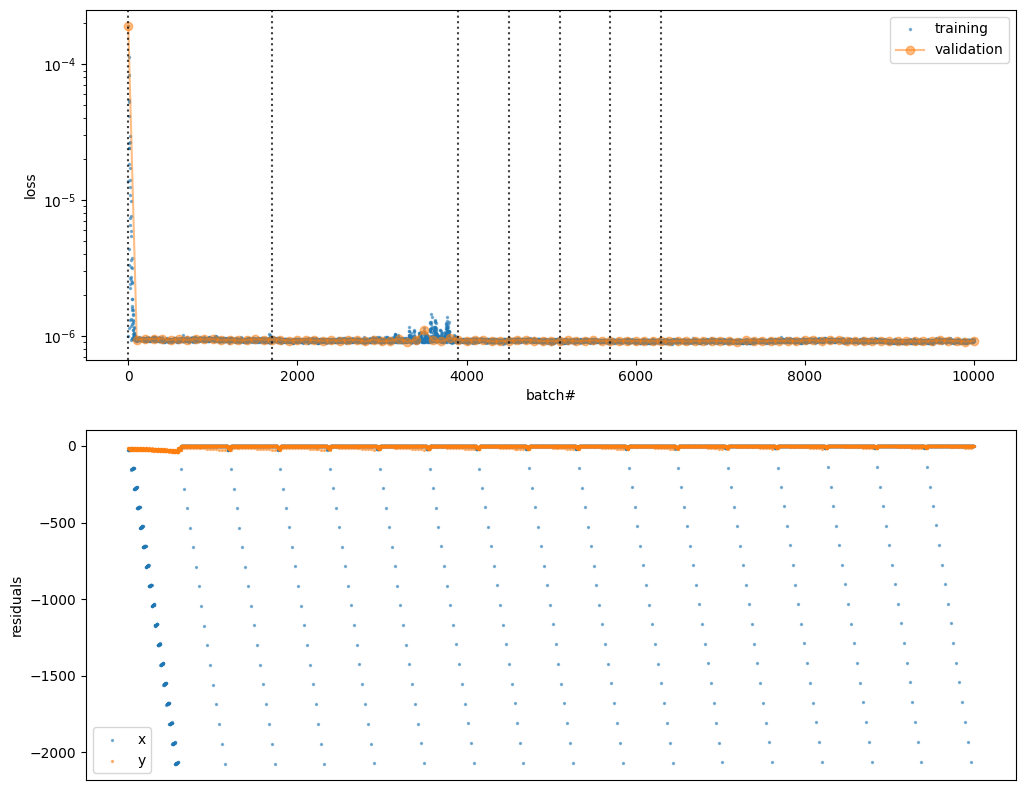

In [53]:
eps = .001

model = RescalingLogLinearSemiComplexPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device)
soln = model.set_coeffs_for_lstsq_solution(grid_ins+eps, grid_outs, filterzeros=False)
print(soln)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=False,
                             pool=(grid_ins+eps, grid_outs), valids=(grid_ins+eps, grid_outs),
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model);

Weird, those ofset ones must be the ones near 0? Probably should just rethink the input scaling to stay positive.

  0%|          | 0/10000 [00:00<?, ?it/s]

Parameter containing:
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [2., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.],
        [0., 2., 0.],
        [0., 1., 1.],
        [0., 0., 2.],
        [3., 0., 0.],
        [2., 1., 0.],
        [2., 0., 1.],
        [1., 2., 0.],
        [1., 1., 1.],
        [1., 0., 2.],
        [0., 3., 0.],
        [0., 2., 1.],
        [0., 1., 2.],
        [0., 0., 3.],
        [4., 0., 0.],
        [3., 1., 0.],
        [3., 0., 1.],
        [2., 2., 0.],
        [2., 1., 1.],
        [2., 0., 2.],
        [1., 3., 0.],
        [1., 2., 1.],
        [1., 1., 2.],
        [1., 0., 3.],
        [0., 4., 0.],
        [0., 3., 1.],
        [0., 2., 2.],
        [0., 1., 3.],
        [0., 0., 4.]], device='cuda:0')

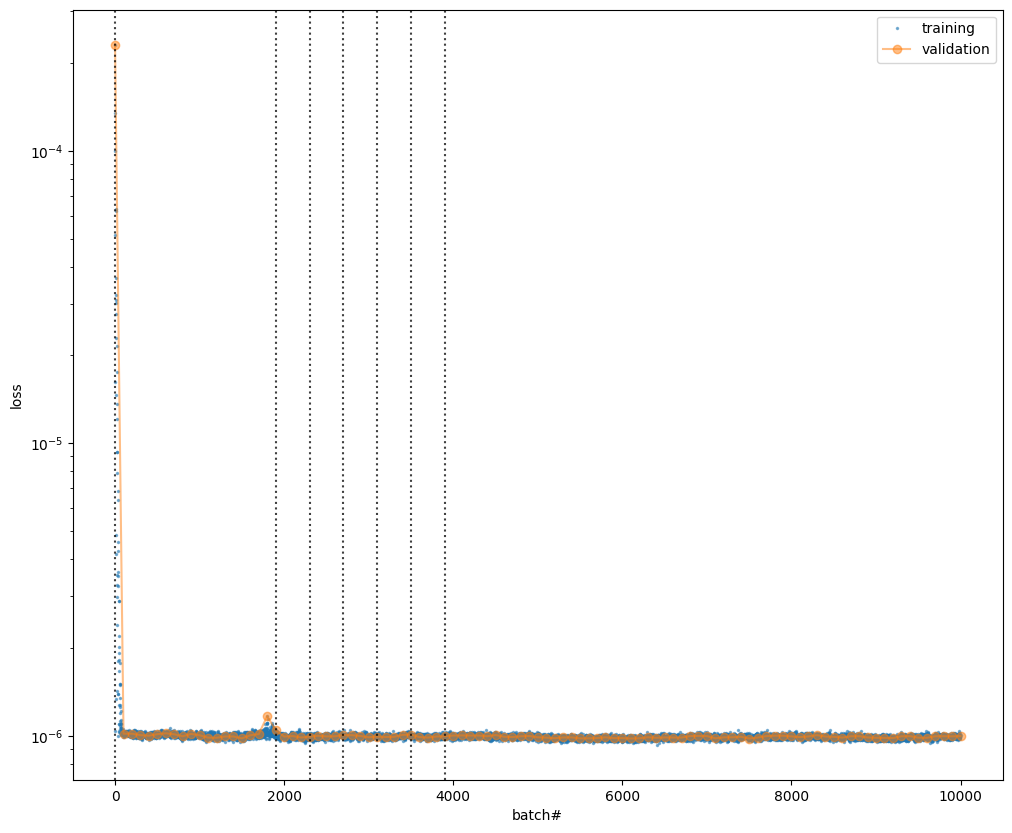

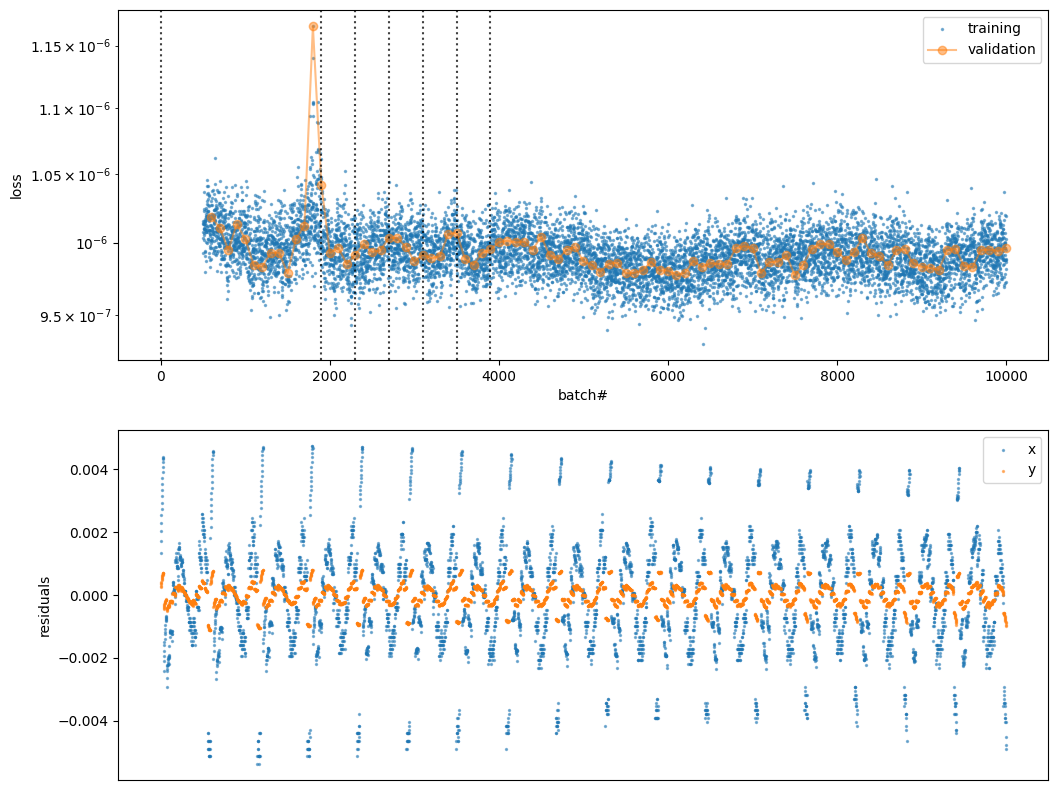

In [54]:
inscale_offset = [(inscale[0][0]-1000, inscale[0][1]), 
                  (inscale[1][0]-.1, inscale[1][1]),
                  (inscale[2][0]-.1, inscale[2][1])]

model = RescalingLogLinearPolyModel(inscale_offset, outscale, 4, fixpolypwr=True).to(torch_device)
soln = model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=False)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=False,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.5, threshold=.001))

training_plots(model, skipstart=-1, residualsplot=False)
training_plots(model,  skipstart=500)
model.poly_linear_layer.weight

Much better! Now lets try allowing the poly layer to vary

  0%|          | 0/150000 [00:00<?, ?it/s]

Parameter containing:
tensor([[-1.4357e-05,  7.9981e-06,  5.9186e-06],
        [ 1.0000e+00,  2.2860e-06,  1.7126e-06],
        [-8.9816e-05,  1.0000e+00,  7.9414e-07],
        [-7.9434e-05,  1.0859e-05,  1.0000e+00],
        [ 2.0000e+00,  1.0014e-06, -4.9855e-05],
        [ 1.0000e+00,  1.0000e+00,  8.1810e-05],
        [ 1.0000e+00,  1.8298e-04,  1.0000e+00],
        [-1.7714e-04,  2.0000e+00, -8.0550e-05],
        [-1.5502e-04,  1.0000e+00,  1.0000e+00],
        [-5.2513e-04,  1.4923e-05,  2.0000e+00],
        [ 3.0000e+00, -5.9697e-07, -1.0081e-04],
        [ 2.0000e+00,  1.0000e+00, -1.8320e-04],
        [ 2.0000e+00, -1.5244e-04,  1.0000e+00],
        [ 1.0000e+00,  2.0000e+00, -9.6373e-05],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 1.0000e+00,  1.7734e-05,  2.0000e+00],
        [ 1.5654e-04,  3.0000e+00,  5.3754e-05],
        [ 9.4841e-05,  2.0000e+00,  1.0000e+00],
        [ 2.4333e-04,  1.0000e+00,  2.0000e+00],
        [ 4.5434e-04, -2.7434e-05,  3.0000e+00]

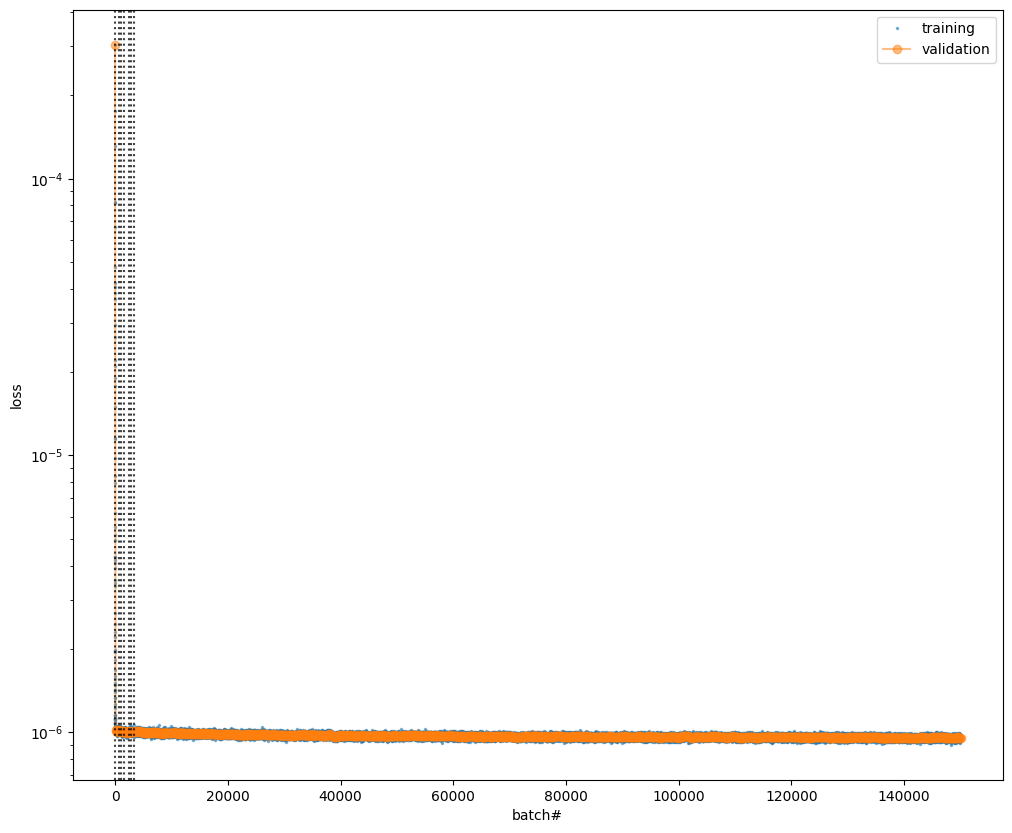

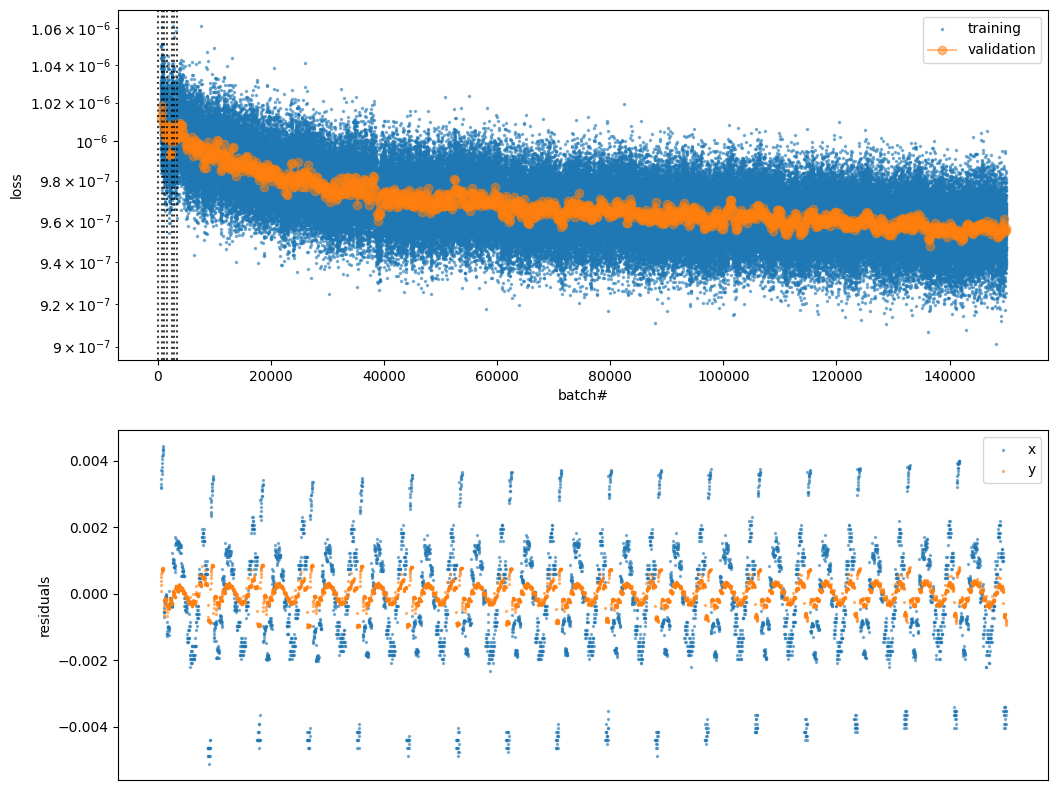

In [55]:
inscale_offset = [(inscale[0][0]-1000, inscale[0][1]), 
                  (inscale[1][0]-.1, inscale[1][1]),
                  (inscale[2][0]-.1, inscale[2][1])]

model = RescalingLogLinearPolyModel(inscale_offset, outscale, 4, fixpolypwr=False).to(torch_device)
soln = model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=False)

model = batch_train_from_pool_nans(model, 1024*10, 150000, 100,mask_nans=False,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=3, factor=.5, threshold=.001))

training_plots(model, skipstart=-1, residualsplot=False)
training_plots(model,  skipstart=500)
model.poly_linear_layer.weight

What if we perturb them some to not lock in the right answer but be in the right ballpark?

  0%|          | 0/150000 [00:00<?, ?it/s]

Parameter containing:
tensor([[-1.1165e-02, -2.9815e-03, -3.0017e-03],
        [ 9.9041e-01, -3.3156e-03, -3.2942e-03],
        [ 4.4898e-02,  9.7771e-01,  4.1019e-03],
        [ 5.0999e-02,  8.6241e-03,  9.6170e-01],
        [ 1.7187e+00,  1.6853e-02,  1.8802e-02],
        [ 1.0209e+00,  4.5810e-01,  3.1106e-02],
        [ 1.0200e+00,  3.2556e-02,  4.6970e-01],
        [ 1.1517e-01,  1.9456e+00,  5.5396e-03],
        [ 6.9937e-02,  9.6235e-01,  9.6154e-01],
        [ 1.1281e-01, -4.4147e-03,  1.9383e+00],
        [ 2.8015e+00,  1.0695e-01,  1.0579e-01],
        [ 1.9041e+00,  7.3835e-01,  3.3407e-02],
        [ 1.9031e+00,  3.7714e-02,  7.3649e-01],
        [ 1.0169e+00,  1.9468e+00,  8.3572e-03],
        [ 1.0290e+00,  9.1135e-01,  9.1039e-01],
        [ 1.0203e+00,  7.6414e-03,  1.9463e+00],
        [-4.6617e-03,  2.9371e+00, -2.4613e-02],
        [ 3.4698e-02,  1.9890e+00,  1.0131e+00],
        [ 3.1905e-02,  1.0102e+00,  1.9857e+00],
        [-3.2060e-05, -2.3051e-02,  2.9352e+00]

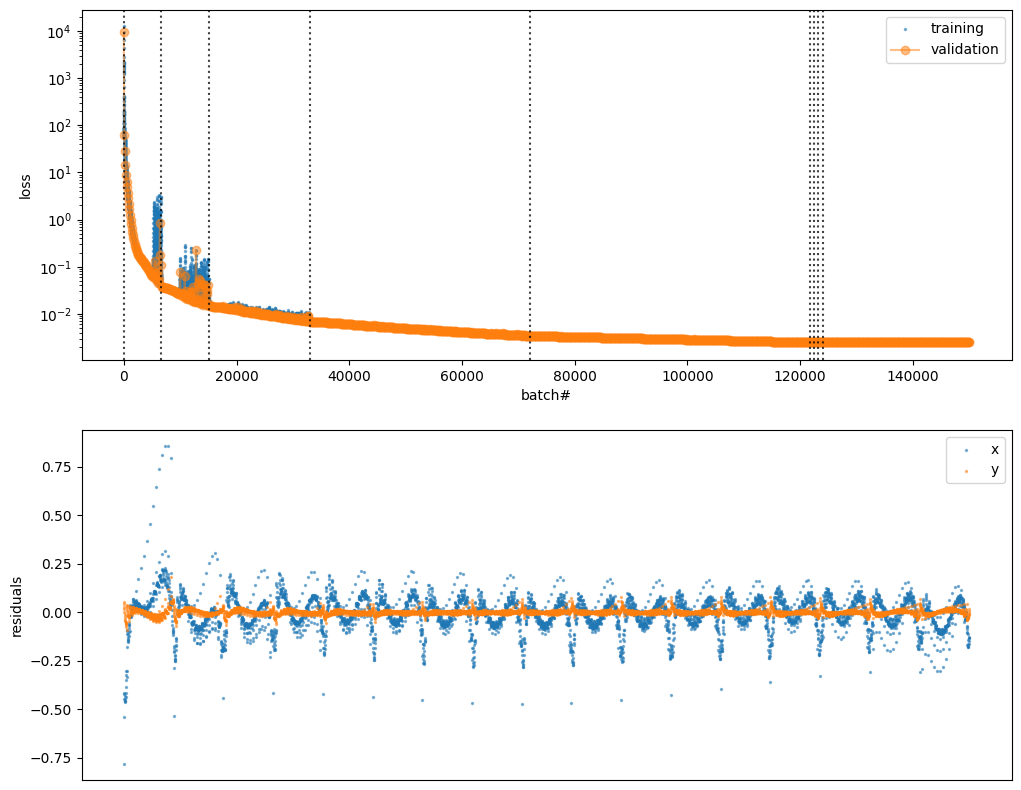

In [57]:
inscale_offset = [(inscale[0][0]-1000, inscale[0][1]), 
                  (inscale[1][0]-.1, inscale[1][1]),
                  (inscale[2][0]-.1, inscale[2][1])]

model = RescalingLogLinearPolyModel(inscale_offset, outscale, 4, fixpolypwr=False).to(torch_device)
soln = model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=False)
model.coeffs.weight = nn.Parameter(model.coeffs.weight.data)

perturbation = torch.rand_like(model.coeffs.weight.data)*.2 +.9
model.coeffs.weight = nn.Parameter(model.coeffs.weight.data*perturbation)

model = batch_train_from_pool_nans(model, 1024*10, 150000, 100,mask_nans=False,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.2, threshold=.001))

training_plots(model)
model.poly_linear_layer.weight

What if we don't fix the coeffs at the outset at all but just run a long time?

  0%|          | 0/2500000 [00:00<?, ?it/s]

Parameter containing:
tensor([[ 8.5996e-01, -2.5019e-04, -8.1090e-03],
        [ 1.1581e+00,  2.2709e-01,  2.0639e-01],
        [ 1.7550e-01,  7.7667e-01,  2.4357e-03],
        [ 1.6019e-01, -8.5818e-03,  5.7881e-01],
        [ 1.0619e+00, -2.2443e-02, -3.9654e-02],
        [ 9.9386e-01,  4.6879e-01,  2.2131e-02],
        [ 8.4604e-01, -1.6424e-02,  5.2768e-01],
        [ 9.1045e-02,  1.7376e+00, -6.2936e-02],
        [ 2.9664e-01,  1.0751e+00,  1.0384e+00],
        [ 2.4461e-01,  6.1625e-02,  2.2672e+00],
        [ 1.5744e+00, -3.1340e-02, -3.4105e-02],
        [ 9.6977e-01, -9.9153e-03, -3.8405e-02],
        [ 1.0172e+00, -2.6068e-02, -3.3545e-03],
        [ 9.8250e-01,  1.2935e+00, -1.5442e-01],
        [ 1.0388e+00, -1.7548e-02, -3.0099e-02],
        [ 1.0341e+00,  9.2224e-03,  1.7346e+00],
        [-7.3029e-02, -1.7306e-02, -3.3084e-02],
        [ 2.4915e-01,  2.4106e+00,  1.0852e+00],
        [ 1.5364e-01,  1.0010e+00,  2.0521e+00],
        [-5.4347e-02, -2.3707e-02,  2.7546e+00]

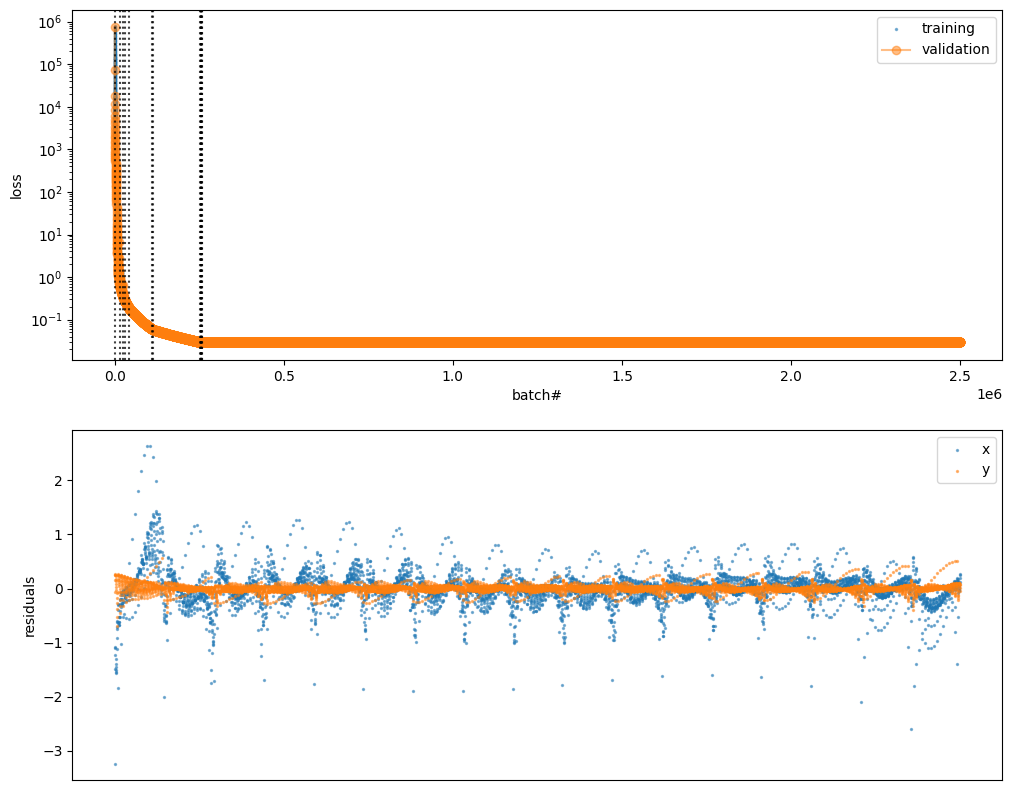

In [58]:
inscale_offset = [(inscale[0][0]-1000, inscale[0][1]), 
                  (inscale[1][0]-.1, inscale[1][1]),
                  (inscale[2][0]-.1, inscale[2][1])]

model = RescalingLogLinearPolyModel(inscale_offset, outscale, 4, fixpolypwr=False).to(torch_device)

model = batch_train_from_pool_nans(model, 1024*20, 2500000, 100,mask_nans=False,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.4, threshold=.001))

training_plots(model)
model.poly_linear_layer.weight

Clearly the polynomial direct-fit just does a ton better... scaling something? At any rate lets just confirm if timing is any different:

In [59]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(20480)/10
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert32(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.3736959993839264


Faster by 3x! How bizzare.

Last thing: can we do away with the output scaling layer?

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([3.8247e-07, 6.4497e-10], device='cuda:0')

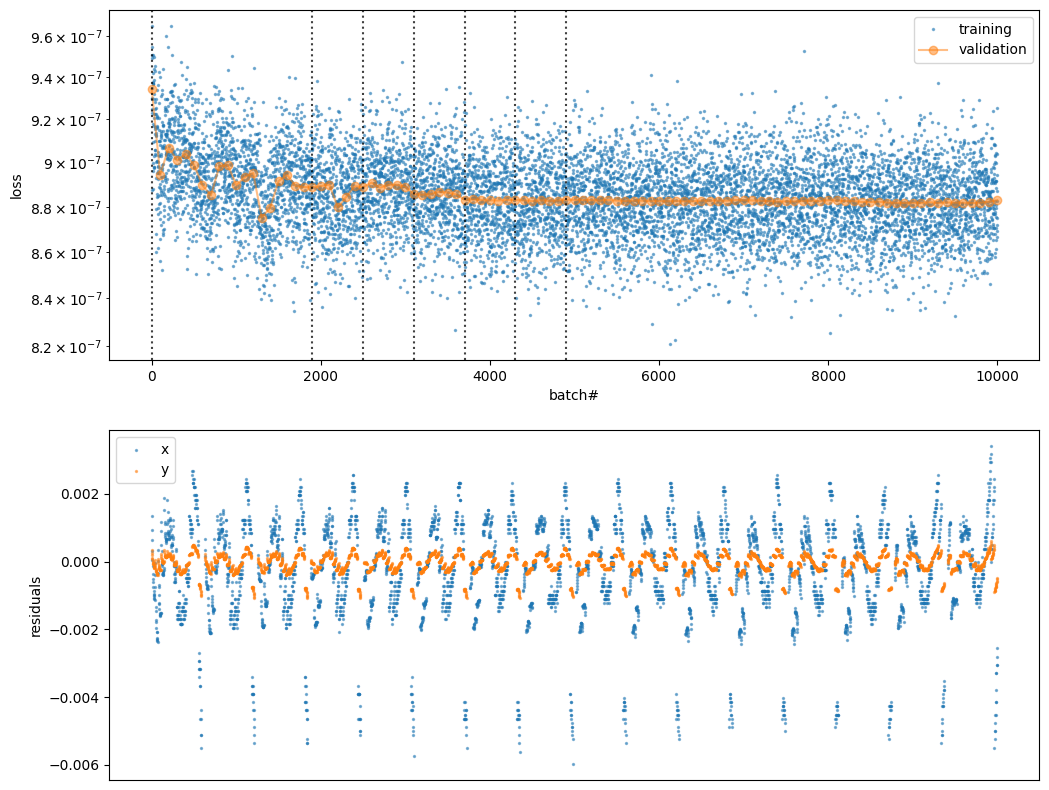

In [37]:
outscale_unity = [(0,1) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale_unity, 4, fixpolypwr=True).to(torch_device, dtype=torch.float32)
soln = model.set_coeffs_for_lstsq_solution(grid_ins, grid_outs, filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.005))

training_plots(model)

soln.residuals**2

Oh interesting seems to be completely unimportant.  Lets give another try with doubles, with and without rescaling and with and without the fixed powers:

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([3.0547e-20, 2.4672e-16], device='cuda:0', dtype=torch.float64)

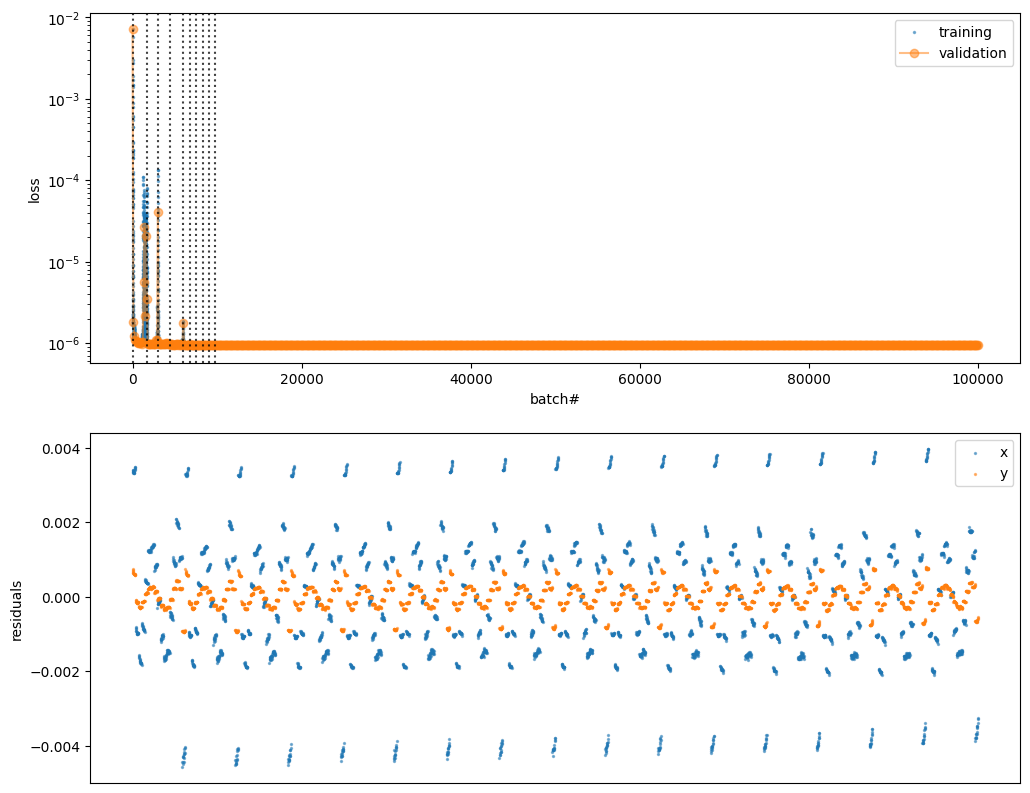

In [53]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=True).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 100,mask_nans=True, dtypeconv=torch.float64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-5, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.0005))

training_plots(model, dtypeconv=torch.float64)

soln.residuals**2

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([5.6764e-07, 8.0885e-10], device='cuda:0', dtype=torch.float64)

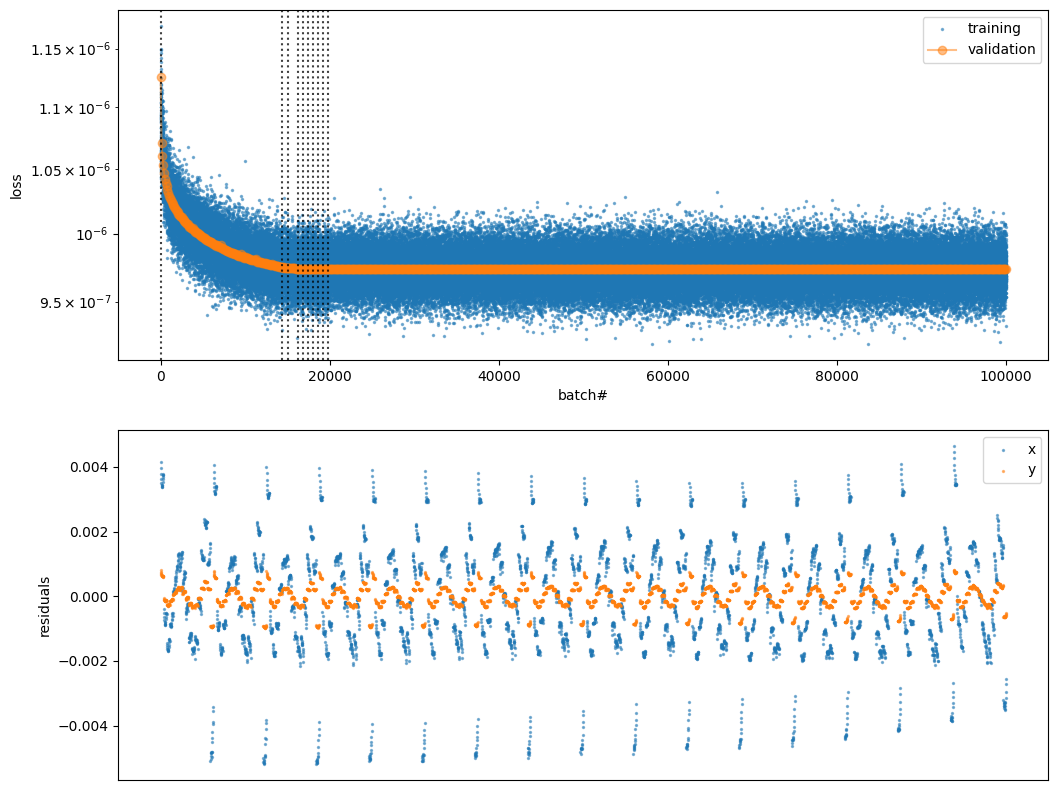

In [52]:
outscale_unity = [(0,1) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale_unity, 4, fixpolypwr=True).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 100,mask_nans=True, dtypeconv=torch.float64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-5, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.0005))

training_plots(model, dtypeconv=torch.float64)

soln.residuals**2

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([3.0547e-20, 2.4672e-16], device='cuda:0', dtype=torch.float64)

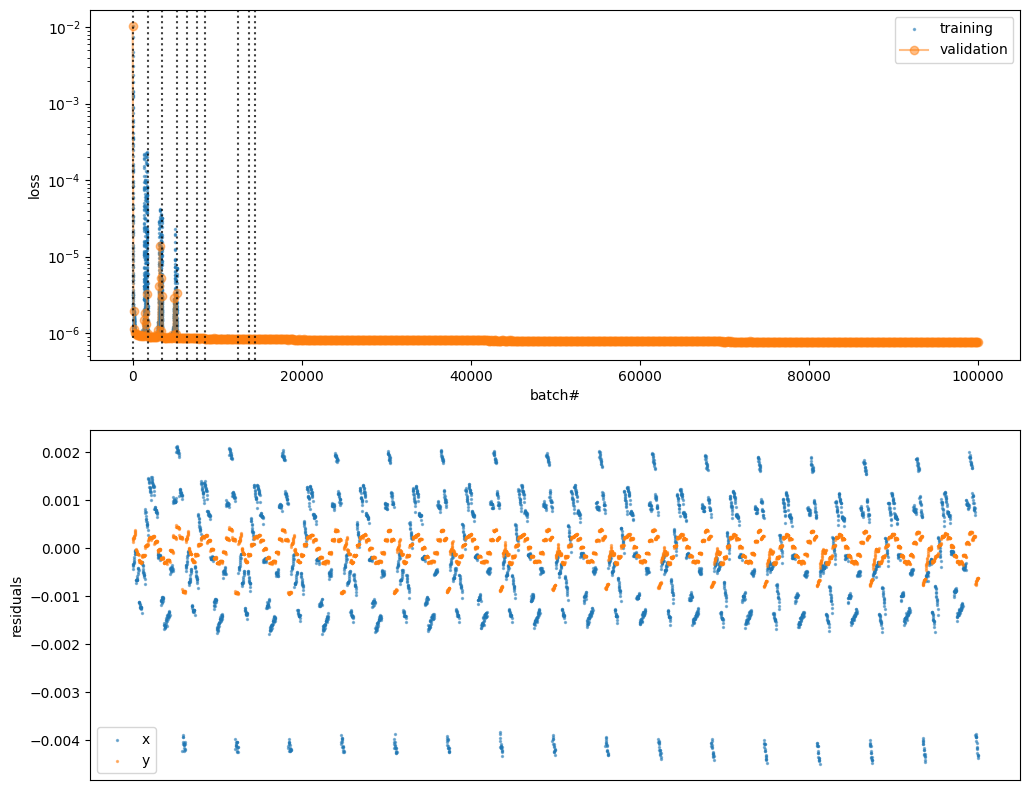

In [54]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=False).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 100,mask_nans=True, dtypeconv=torch.float64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-5, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.0005))

training_plots(model, dtypeconv=torch.float64)

soln.residuals**2

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([5.6764e-07, 8.0885e-10], device='cuda:0', dtype=torch.float64)

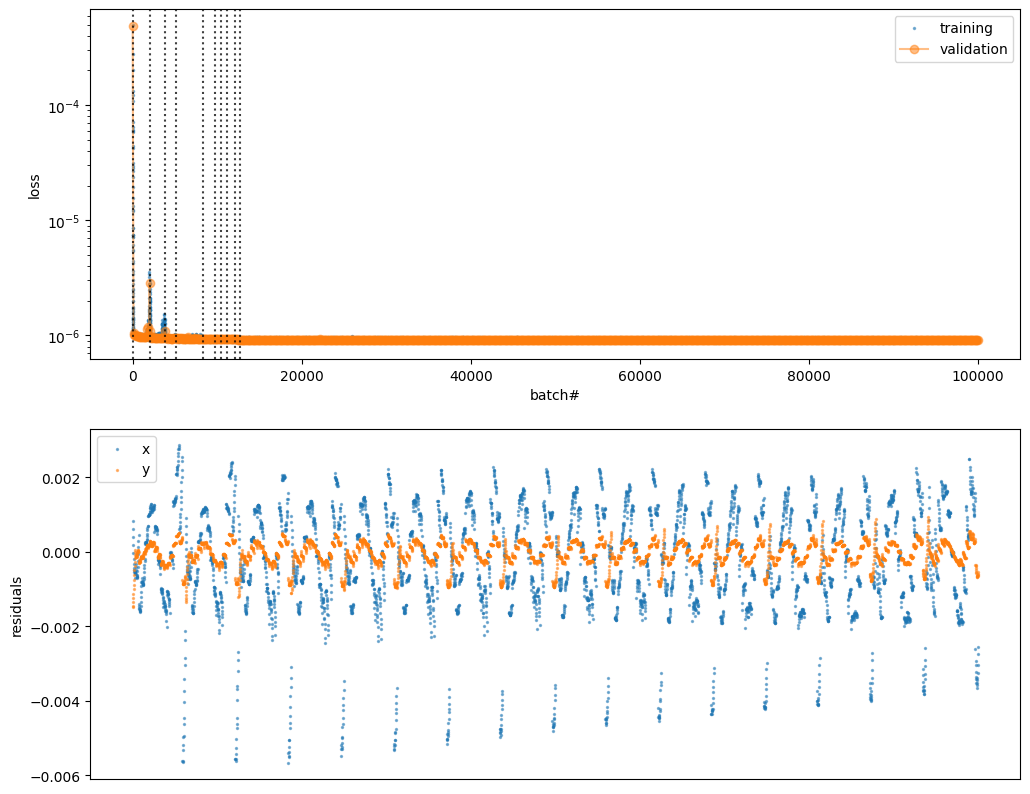

In [55]:
outscale_unity = [(0,1) for i in range(grid_outs.shape[-1])]
model = RescalingLogLinearPolyModel(inscale, outscale_unity, 4, fixpolypwr=False).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 100000, 100,mask_nans=True, dtypeconv=torch.float64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-5, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.0005))

training_plots(model, dtypeconv=torch.float64)

soln.residuals**2

What about no nn training?

(1.1312900298131e-06,
 torch.return_types.linalg_lstsq(
 solution=tensor([[ 1.3334e-02,  2.9928e-01],
         [ 9.7462e-01,  1.6869e-02],
         [-7.4666e-03, -2.9921e-01],
         [-5.8707e-03,  3.3968e-01],
         [ 1.0090e-02,  3.2971e-01],
         [-1.6840e-04, -5.0456e-03],
         [-7.6662e-05, -3.6906e-03],
         [ 6.9339e-06, -9.1131e-06],
         [-3.4868e-06,  5.7244e-05],
         [ 9.1326e-07, -5.6514e-05],
         [ 7.7045e-04, -2.3089e-03],
         [-3.7109e-05, -8.1358e-04],
         [-3.5814e-05,  6.0092e-04],
         [-4.0197e-06, -4.5867e-05],
         [ 3.3438e-06,  2.7344e-05],
         [-1.2036e-05, -1.2140e-04],
         [-1.1534e-05, -1.0007e-04],
         [ 9.8041e-06,  9.4006e-05],
         [-4.5402e-06, -4.3820e-05],
         [ 5.8424e-06,  3.3592e-05],
         [ 1.1784e-03,  1.9907e-02],
         [-3.3249e-05, -8.6839e-04],
         [-8.1881e-06,  3.7838e-05],
         [ 1.1739e-05,  1.3471e-04],
         [-1.1853e-05, -1.2549e-04],
         [

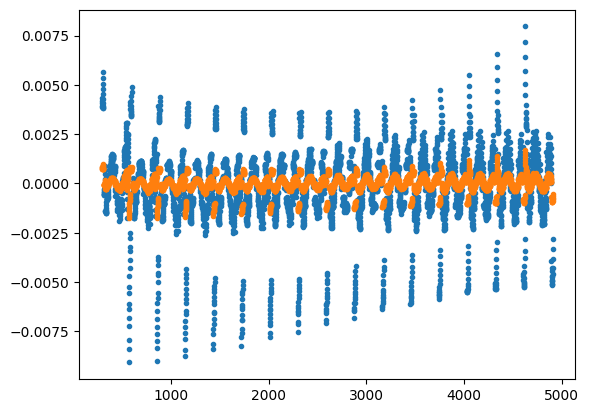

In [96]:
model = RescalingLogLinearPolyModel(inscale, outscale, 4, fixpolypwr=False).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

plt.plot((model(dconvert64(ins_plot)) - dconvert64(outs_plot)).cpu().detach(), '.')

msk = ~torch.any(model.inscale_layer(dconvert64(grid_ins)) <= 0, 3)
nn.MSELoss().to(torch_device, dtype=torch.float64)(model(dconvert64(grid_ins[msk])), dconvert64(grid_outs[msk])).item(), soln

How much slower are doubles?

In [97]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(20480)/10
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert64(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.6229119896888733


Surprisingly consistent! But apparently not worth it for precision... What about the regular model but with more precision?

9.431492876897876e-07

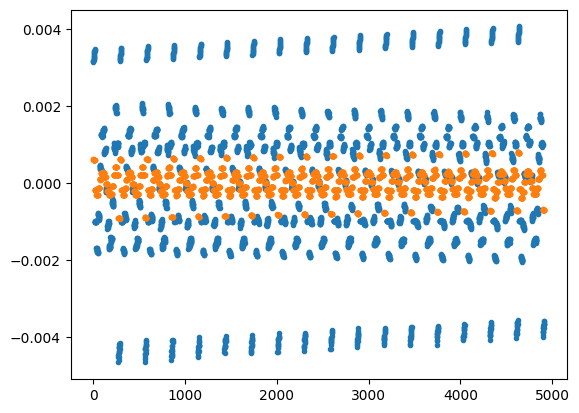

In [99]:
grid_ins64, grid_outs64 = make_grid_3feature((100,100,100), slit, dconvert=dconvert64)
ins_plot64, outs_plot64 = make_grid_3feature((17,17,17), slit, flatten=True, dconvert=dconvert64)

model = RescalingPolyModel(inscale, outscale, 4).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins64, grid_outs64)

plt.plot((model(ins_plot64) - outs_plot64).cpu().detach(), '.')

msk = ~torch.any(model.inscale_layer(grid_ins64) <= 0, 3)
nn.MSELoss().to(torch_device, dtype=torch.float64)(model(grid_ins64[msk]), grid_outs64[msk]).item()

9.709319294771746e-09

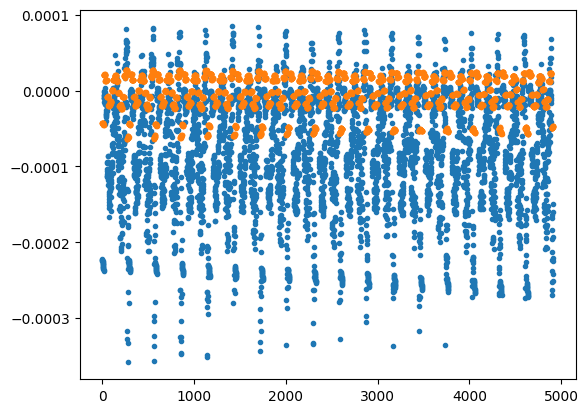

In [111]:
grid_ins64, grid_outs64 = make_grid_3feature((100,100,100), slit, dconvert=dconvert64)
ins_plot64, outs_plot64 = make_grid_3feature((17,17,17), slit, flatten=True, dconvert=dconvert64)

model = RescalingPolyModel(inscale, outscale, 5).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins64, grid_outs64)

plt.plot((model(ins_plot64) - outs_plot64).cpu().detach(), '.')

msk = ~torch.any(model.inscale_layer(grid_ins64) <= 0, 3)
nn.MSELoss().to(torch_device, dtype=torch.float64)(model(grid_ins64[msk]), grid_outs64[msk]).item()

Seems limited by the poly power...

1.1955129422634697e-08

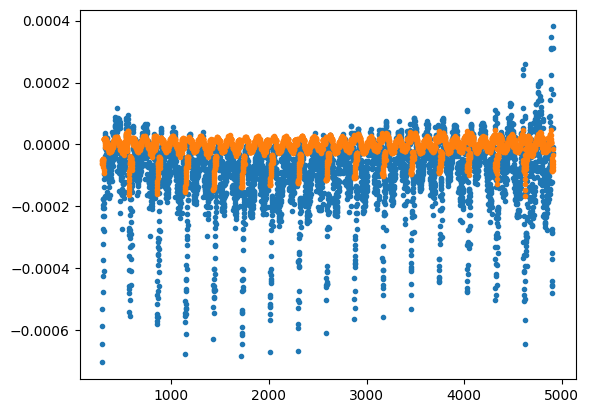

In [116]:
model = RescalingLogLinearPolyModel(inscale, outscale, 5, fixpolypwr=False).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

plt.plot((model(ins_plot64) - outs_plot64).cpu().detach(), '.')

msk = ~torch.any(model.inscale_layer(grid_ins64) <= 0, 3)
nn.MSELoss().to(torch_device, dtype=torch.float64)(model(grid_ins64[msk]), grid_outs64[msk]).item()

In [117]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

wla = torch.arange(20480)/10
ro = torch.zeros_like(wla)
do = torch.zeros_like(wla)
ins_speed = dconvert64(torch.stack((wla, ro, do), dim=-1))

with torch.no_grad():
    start.record()
    model(ins_speed)
    end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end)) #ms

0.8159999847412109


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([3.0956e-24, 4.9790e-21], device='cuda:0', dtype=torch.float64)

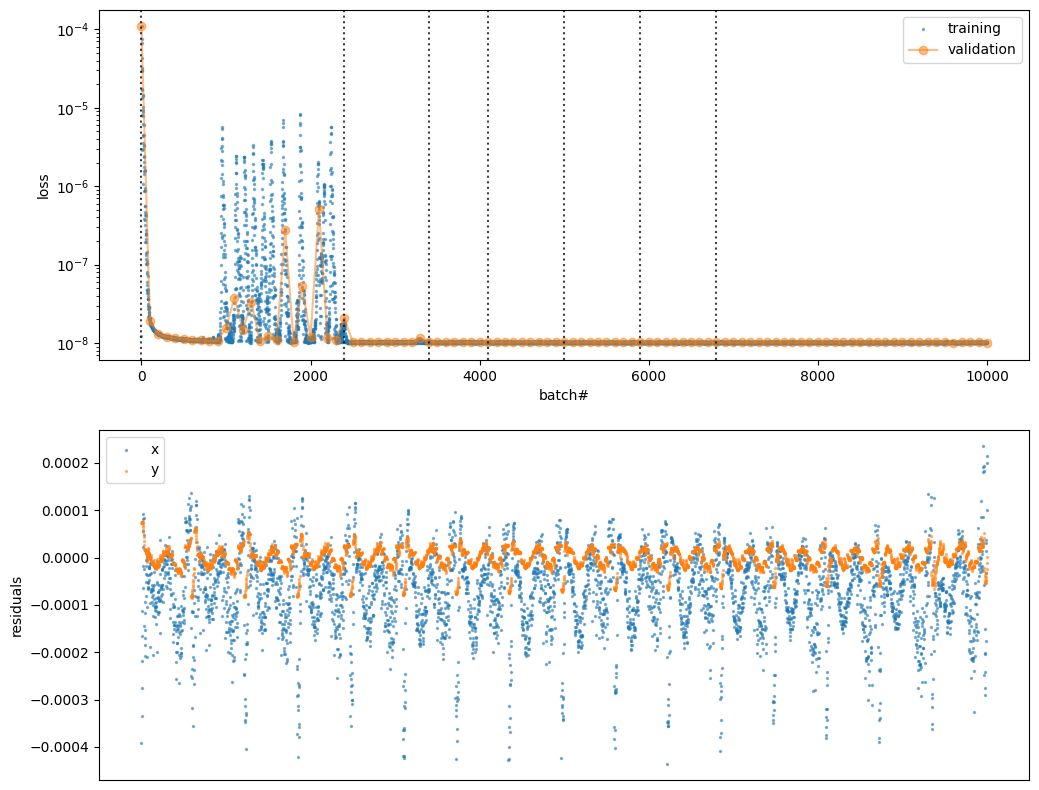

In [119]:
model = RescalingLogLinearPolyModel(inscale, outscale, 5, fixpolypwr=False).to(torch_device, dtype=torch.float64)
soln = model.set_coeffs_for_lstsq_solution(grid_ins.to(dtype=torch.float64), grid_outs.to(dtype=torch.float64), filterzeros=True)

model = batch_train_from_pool_nans(model, 1024*10, 10000, 100,mask_nans=True, dtypeconv=torch.float64,
                             optimizer=lambda m: torch.optim.Adam(m.parameters(), lr=1e-6, fused=False),
scheduler_gen=lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=.5, threshold=.0005))

training_plots(model, dtypeconv=torch.float64)

soln.residuals**2

Well we don't lose a lot of time at a higher power so its just a matter of whether its worth the precision.